<img src='https://www.osicild.org/uploads/1/2/2/7/122798879/editor/kaggle-v01-clipped.png?1569346633'>
<h1><center>OSIC Pulmonary Fibrosis Progression - EDA</center><h1>
    
# 1. <a id='Introduction'>Introduction 🃏 </a>
    
###  1.1 What is Pulmonary fibrosis?
* [Pulmonary fibrosis is a lung disease that occurs when lung tissue becomes damaged and scarred.](https://www.mayoclinic.org/diseases-conditions/pulmonary-fibrosis/symptoms-causes/syc-20353690)  This thickened, stiff tissue makes it more difficult for your lungs to work properly. If you want to know further about this type lung disease, I have linked below an informative video.

In [1]:
from IPython.display import HTML
HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/AfK9LPNj-Zo" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

###  1.2 What is OSIC Pulmonary Fibrosis Progression Competition?
- In this competition, you’ll predict a patient’s severity of decline in lung function based on a CT scan of their lungs. You’ll determine lung function based on output from a spirometer, which measures the volume of air inhaled and exhaled. The challenge is to use machine learning techniques to make a prediction with the image, metadata, and baseline FVC as input.
    
    
###  1.3 What we need to do? Observation
We will predict a patient’s severity of decline in lung function based on a CT scan of their lungs.
In other words, We will predict the final three FVC measurements for each patient, as well as a confidence value in your prediction.
    
- The leaderboard of this competition is calculated with approximately 1%->15% of the test data. The final results will be based on the other 99%->85%, so the final standings may be different.
    
###  1.4 Metric: Laplace Log Likelihood
![](https://i.imgur.com/tEIZvli.png)
- Image Credits: https://en.wikipedia.org/wiki/Laplace_distribution
    
- The evaluation metric of this competition is a modified version of Laplace Log Likelihood. 
Predictions are evaluated with a modified version of the Laplace Log Likelihood. For each sample in test set, an `FVC` and a `Confidence` measure (standard deviation σ) has to be predicted.

    `Confidence` values smaller than 70 are clipped.

    $\large \sigma_{clipped} = max(\sigma, 70),$

    Errors greater than 1000 are also clipped in order to avoid large errors.

    $\large \Delta = min ( |FVC_{true} - FVC_{predicted}|, 1000 ),$

    The metric is defined as:

    $\Large metric = -   \frac{\sqrt{2} \Delta}{\sigma_{clipped}} - \ln ( \sqrt{2} \sigma_{clipped} ).$


Read more about it on the [Evaluation Page](https://www.kaggle.com/c/osic-pulmonary-fibrosis-progression/overview/evaluation).

If you feel this was something new and fresh, and it added some value to you, please consider <font color='orange'>upvoting</font>, it motivates to keep writing good kernels. 😄

## <font size='5' color='blue'>Contents</font> 



* [Basic Exploratory Data Analysis](#1)  
    * [Getting started - Importing libraries]()
    * [Reading the train.csv]()
    
 
* [Data Exploration](#2)   
     * [Check Train & Test Info.]()
     * [Unique Patients(Ids)]()
     * [Exploring the 'SmokingStatus' column]()
     * [Weeks distribution]()
     * [FVC - The forced vital capacity]()
     * [Exploring the Percent column]()
     * [Gender Distribution]()
     * [Patient Overlap]()
     
 
* [Visualising Images : DECOM](#3)    
     * [Visualising One DECOM Image & Info.]()
     * [Visualising Multiple DECOM Images]()
     * [Visualization using gif]()
     
     
* [Extracting DIOCOM files Info.](#4)


* [Pandas Profiling](#5)
     * [Pandas Profiling Report for Train.csv]()
     * [Pandas Profiling Report for Test.csv]()


# 2. <a id='importing'>Importing the necessary libraries📗</a> 

In [2]:
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import tqdm
from typing import Dict
import matplotlib.pyplot as plt
%matplotlib inline

#plotly
!pip install chart_studio
import plotly.express as px
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

#color
from colorama import Fore, Back, Style

import seaborn as sns
sns.set(style="whitegrid")

#pydicom
import pydicom

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()

You should consider upgrading via the 'c:\users\alexander\envs\pew\scripts\python.exe -m pip install --upgrade pip' command.


# 3. <a id='reading'>Reading the train.csv 📚</a>

In [3]:
# List files available
list(os.listdir("data"))

['test', 'train', 'sample_submission.csv', 'test.csv', 'train.csv']

In [4]:
IMAGE_PATH = "data/"

train_df = pd.read_csv(f'{IMAGE_PATH}/train.csv')
test_df = pd.read_csv(f'{IMAGE_PATH}/test.csv')

print(Fore.YELLOW + 'Training data shape: ',Style.RESET_ALL,train_df.shape)
train_df.head(5)

Training data shape:   (1549, 7)


Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker

In [5]:
train_df.groupby(['SmokingStatus']).count()['Sex'].to_frame()

Sex
SmokingStatus         
Currently smokes    82
Ex-smoker         1038
Never smoked       429

# 4. <a id='basic'>Basic Data Exploration 🏕️</a> 

## General Info

In [6]:
# Null values and Data types
print(Fore.YELLOW + 'Train Set !!',Style.RESET_ALL)
print(train_df.info())
print('-------------')
print(Fore.BLUE + 'Test Set !!',Style.RESET_ALL)
print(test_df.info())

Train Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
Patient          1549 non-null object
Weeks            1549 non-null int64
FVC              1549 non-null int64
Percent          1549 non-null float64
Age              1549 non-null int64
Sex              1549 non-null object
SmokingStatus    1549 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB
None
-------------
Test Set !! 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 7 columns):
Patient          5 non-null object
Weeks            5 non-null int64
FVC              5 non-null int64
Percent          5 non-null float64
Age              5 non-null int64
Sex              5 non-null object
SmokingStatus    5 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 408.0+ bytes
None


The type of Percent column is float64.

### Missing values

In [7]:
train_df.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

In [8]:
test_df.isnull().sum()

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64

There is no missing values in train_df and test_df.

In [9]:
# Total number of Patient in the dataset(train+test)

print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
print(Fore.BLUE +"Total Patients in Test set: ",Style.RESET_ALL,test_df['Patient'].count())

Total Patients in Train set:   1549
Total Patients in Test set:   5


 `5` : Patients in Test Set

## Unique Patients(Ids)

In [10]:
print(Fore.YELLOW + "The total patient ids are",Style.RESET_ALL,f"{train_df['Patient'].count()},", Fore.BLUE + "from those the unique ids are", Style.RESET_ALL, f"{train_df['Patient'].value_counts().shape[0]}.")

The total patient ids are  1549, from those the unique ids are  176.


In [11]:
train_patient_ids = set(train_df['Patient'].unique())
test_patient_ids = set(test_df['Patient'].unique())

train_patient_ids.intersection(test_patient_ids)

{'ID00419637202311204720264',
 'ID00421637202311550012437',
 'ID00422637202311677017371',
 'ID00423637202312137826377',
 'ID00426637202313170790466'}

We already see `5` patients in test set that can be found in train set as well.

In [12]:
columns = train_df.keys()
columns = list(columns)
print(columns)

['Patient', 'Weeks', 'FVC', 'Percent', 'Age', 'Sex', 'SmokingStatus']


### Patient Counts

In [13]:
train_df['Patient'].value_counts().max()

10

In train set, there are multiple rows for one 'Patient'. Because Patient has different weeks, FVC, Percent.

In [14]:
test_df['Patient'].value_counts().max()

1

In test set, we can see one Patient and it mean Patient id is unique.

In [15]:
np.quantile(train_df['Patient'].value_counts(), 0.75) - np.quantile(test_df['Patient'].value_counts(), 0.25)

8.0

In [16]:
print(np.quantile(train_df['Patient'].value_counts(), 0.95))
print(np.quantile(test_df['Patient'].value_counts(), 0.95))

10.0
1.0


## Number of Patients and Images in Training Images Folder
* https://www.kaggle.com/yeayates21/osic-simple-image-eda

In [17]:
files = folders = 0

path = f'{IMAGE_PATH}/train'

for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)
#print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
print(Fore.YELLOW +f'{files:,}',Style.RESET_ALL,"files/images, " + Fore.BLUE + f'{folders:,}',Style.RESET_ALL ,'folders/patients')

33,026  files/images, 176  folders/patients


In [18]:
files = []
for _, dirnames, filenames in os.walk(path):
  # ^ this idiom means "we won't be using this value"
    files.append(len(filenames))

print(Fore.YELLOW +f'{round(np.mean(files)):,}',Style.RESET_ALL,'average files/images per patient')
print(Fore.BLUE +f'{round(np.max(files)):,}',Style.RESET_ALL, 'max files/images per patient')

187.0  average files/images per patient
1,018  max files/images per patient


# 5. <a id='details'>Data Exploration in Details 🎠</a> 

## Creating Individual Patient Dataframe

for `175` unique patients, we make new dataframe

Thanks [@wjdanalharthi](https://www.kaggle.com/wjdanalharthi)

In [19]:
patient_df = train_df[['Patient', 'Age', 'Sex', 'SmokingStatus']].drop_duplicates()
patient_df.head()

Patient  Age   Sex SmokingStatus
0   ID00007637202177411956430   79  Male     Ex-smoker
9   ID00009637202177434476278   69  Male     Ex-smoker
18  ID00010637202177584971671   60  Male     Ex-smoker
27  ID00011637202177653955184   72  Male     Ex-smoker
36  ID00012637202177665765362   65  Male  Never smoked

You can use this:
- https://www.kaggle.com/redwankarimsony/pulmonary-fibrosis-progression-interactive-eda

In [20]:
# Creating unique patient lists and their properties. 
train_dir = f'{IMAGE_PATH}/train/'
test_dir = f'{IMAGE_PATH}/test/'

patient_ids = os.listdir(train_dir)
patient_ids = sorted(patient_ids)

#Creating new rows
no_of_instances = []
age = []
sex = []
smoking_status = []

for patient_id in patient_ids:
    patient_info = train_df[train_df['Patient'] == patient_id].reset_index()
    no_of_instances.append(len(os.listdir(train_dir + patient_id)))
    age.append(patient_info['Age'][0])
    sex.append(patient_info['Sex'][0])
    smoking_status.append(patient_info['SmokingStatus'][0])

#Creating the dataframe for the patient info    
patient_df = pd.DataFrame(list(zip(patient_ids, no_of_instances, age, sex, smoking_status)), 
                                 columns =['Patient', 'no_of_instances', 'Age', 'Sex', 'SmokingStatus'])
print(patient_df.info())
patient_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 5 columns):
Patient            176 non-null object
no_of_instances    176 non-null int64
Age                176 non-null int64
Sex                176 non-null object
SmokingStatus      176 non-null object
dtypes: int64(2), object(3)
memory usage: 7.0+ KB
None


Patient  no_of_instances  Age   Sex SmokingStatus
0  ID00007637202177411956430               30   79  Male     Ex-smoker
1  ID00009637202177434476278              394   69  Male     Ex-smoker
2  ID00010637202177584971671              106   60  Male     Ex-smoker
3  ID00011637202177653955184               31   72  Male     Ex-smoker
4  ID00012637202177665765362               49   65  Male  Never smoked

## Exploring the 'SmokingStatus' column

In [21]:
patient_df['SmokingStatus'].value_counts()

Ex-smoker           118
Never smoked         49
Currently smokes      9
Name: SmokingStatus, dtype: int64

In [22]:
patient_df['SmokingStatus'].value_counts().iplot(kind='bar',
                                              yTitle='Counts', 
                                              linecolor='black', 
                                              opacity=0.7,
                                              color='blue',
                                              theme='pearl',
                                              bargap=0.5,
                                              gridcolor='white',
                                              title='Distribution of the SmokingStatus column in the Unique Patient Set')

`118` : Ex-smoker

`49` : Never smoked

`9` : Currently smokes

## Weeks distribution

In [23]:
train_df['Weeks'].value_counts().head()

8     45
12    44
18    42
10    41
6     40
Name: Weeks, dtype: int64

In [24]:
train_df['Weeks'].value_counts().iplot(kind='barh',
                                      xTitle='Counts(Weeks)', 
                                      linecolor='black', 
                                      opacity=0.7,
                                      color='#FB8072',
                                      theme='pearl',
                                      bargap=0.2,
                                      gridcolor='white',
                                      title='Distribution of the Weeks in the training set')

In [25]:
train_df['Weeks'].iplot(kind='hist',
                              xTitle='Weeks', 
                              yTitle='Counts',
                              linecolor='black', 
                              opacity=0.7,
                              color='#FB8072',
                              theme='pearl',
                              bargap=0.2,
                              gridcolor='white',
                              title='Distribution of the Weeks in the training set')

There are some negative values for Weeks. 

Because Weeks is the relative number of weeks pre/post the baseline CT.

## Distribution Age over Week

In [26]:
fig = px.scatter(train_df, x="Weeks", y="Age", color='Sex')
fig.show()

## FVC - The forced vital capacity

 The forced vital capacity (FVC), i.e. the volume of air exhaled
 - the recorded lung capacity in ml

In [27]:
train_df['FVC'].value_counts()

2095    4
2889    4
2474    4
2965    4
2694    4
       ..
3313    1
3661    1
3299    1
5895    1
4096    1
Name: FVC, Length: 1202, dtype: int64

In [28]:
train_df['FVC'].iplot(kind='hist',
                      xTitle='Lung Capacity(ml)', 
                      linecolor='black', 
                      opacity=0.8,
                      color='#FB8072',
                      bargap=0.5,
                      gridcolor='white',
                      title='Distribution of the FVC in the training set')

### FVC vs Percent

In [29]:
fig = px.scatter(train_df, x="FVC", y="Percent", color='Age')
fig.show()

FVC seems to related Percent linearly. Makes sense as both terms are proportional.

### FVC vs Age

In [30]:
fig = px.scatter(train_df, x="FVC", y="Age", color='Sex')
fig.show()

Males have higher FVC than females irrespective of age

### FVC vs Weeks

In [31]:
fig = px.scatter(train_df, x="FVC", y="Weeks", color='SmokingStatus')
fig.show()

### Pick one patient for FVC vs Weeks

In [32]:
tmp_patients = np.unique(train_df.Patient.values)

In [33]:
patient = train_df[train_df.Patient == 'ID00228637202259965313869']
fig = px.line(patient, x="Weeks", y="FVC", color='SmokingStatus')
fig.show()

In [34]:
patient = train_df[train_df.Patient == tmp_patients[0]]
fig = px.line(patient, x="Weeks", y="FVC", color='SmokingStatus')
fig.show()

In [35]:
patient = train_df[train_df.Patient == tmp_patients[1]]
fig = px.line(patient, x="Weeks", y="FVC", color='SmokingStatus')
fig.show()

In [36]:
patient = train_df[train_df.Patient == tmp_patients[2]]
fig = px.line(patient, x="Weeks", y="FVC", color='SmokingStatus')
fig.show()

In [37]:
patient = train_df[train_df.Patient == tmp_patients[3]]
fig = px.line(patient, x="Weeks", y="FVC", color='SmokingStatus')
fig.show()

In [38]:
patient = train_df[train_df.Patient == tmp_patients[11]]
fig = px.line(patient, x="Weeks", y="FVC", color='SmokingStatus')
fig.show()

In [39]:
def plot_n_deg_polynom_for_patient(patient, deg=3):
    tmp_df = train_df[train_df.Patient == tmp_patients[patient]]
    x = tmp_df.Weeks
    y = tmp_df.FVC
    poly = np.poly1d(np.polyfit(x, y, deg))
#     x_for_poly = np.linspace(np.min(x), np.max(x))
    x_for_poly = np.linspace(-12, 133)
    plt.plot(x_for_poly, poly(x_for_poly))  # np.linspace(0, 100), poly(np.linspace(0, 100)))  # *f(x.astype(float), res)
    plt.plot(x, y)
    return x, y, poly

In [59]:
def plot_n_deg_polynom_for_patient_with_hack(patient, deg=3):
    tmp_df = train_df[train_df.Patient == tmp_patients[patient]]
    x = tmp_df.Weeks
    y = tmp_df.FVC
    x = np.r_[-12, x, 133]
    y = np.r_[y.max(), y, y.min()]
    poly = np.poly1d(np.polyfit(x, y, deg))
#     x_for_poly = np.linspace(np.min(x), np.max(x))
    x_for_poly = np.linspace(-12, 133)
    plt.plot(x_for_poly, poly(x_for_poly))  # np.linspace(0, 100), poly(np.linspace(0, 100)))  # *f(x.astype(float), res)
    plt.plot(x[1:-1], y[1:-1])
    return x, y, poly

In [49]:
max_week = train_df.Weeks.max()
train_df[train_df.Weeks == max_week]

Patient  Weeks   FVC    Percent  Age   Sex  \
624  ID00165637202237320314458    133  2184  55.902529   54  Male   

    SmokingStatus  
624     Ex-smoker

In [50]:
train_df.Weeks.describe()

count    1549.000000
mean       31.861846
std        23.247550
min        -5.000000
25%        12.000000
50%        28.000000
75%        47.000000
max       133.000000
Name: Weeks, dtype: float64

43.675848770883555 77.70603664817008


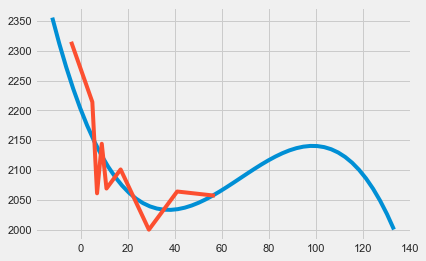

82.7277911282343 170.13669138062733


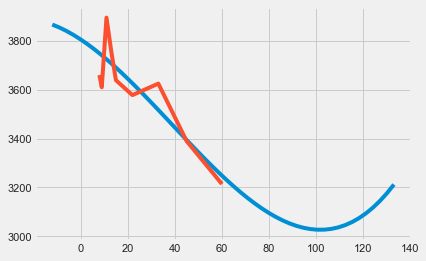

131.22783600589705 221.7387826342374


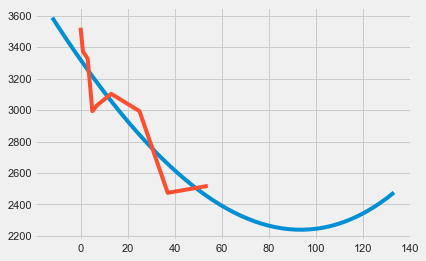

65.66151826341034 137.39037513106132


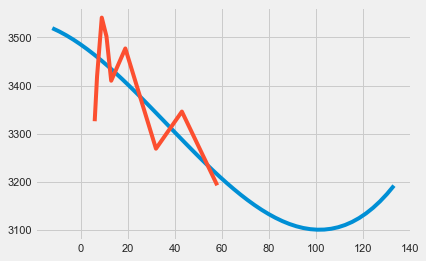

121.58409123736287 282.12790613851666


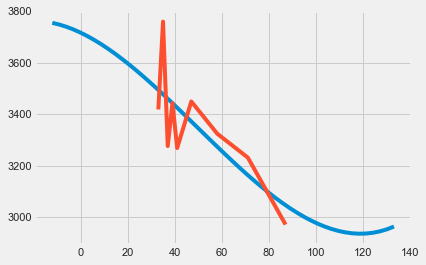

144.39839895264518 302.54354694126005


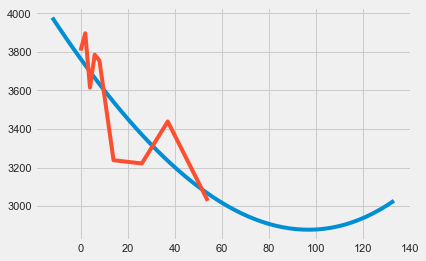

109.37456403233786 249.52783798987593


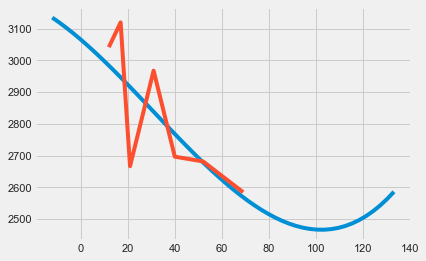

41.41394093075968 104.30743602222628


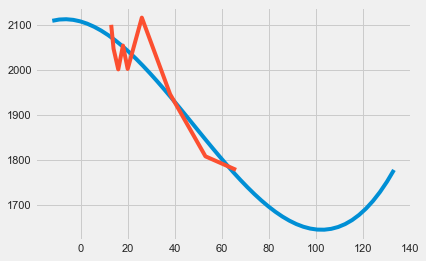

46.92471367858243 83.20919229052242


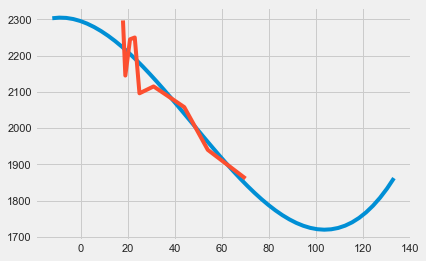

91.23162560444781 233.32513054691208


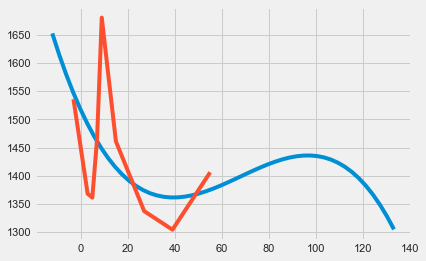

108.30706245117906 266.9922493446602


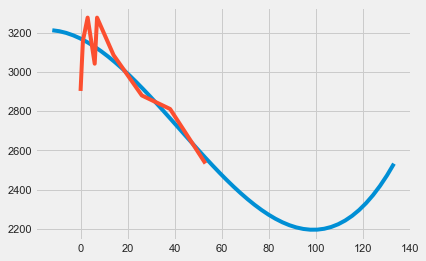

79.21487281098601 156.19917582771677


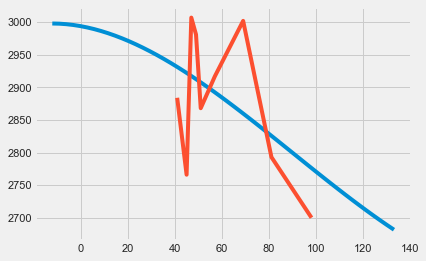

112.11426873031273 259.95492011230453


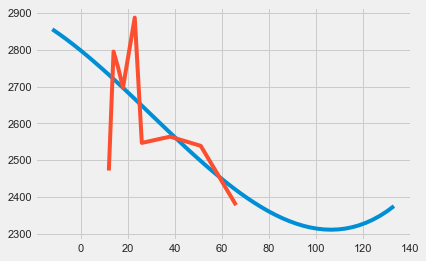

87.76684146293948 163.9812383053436


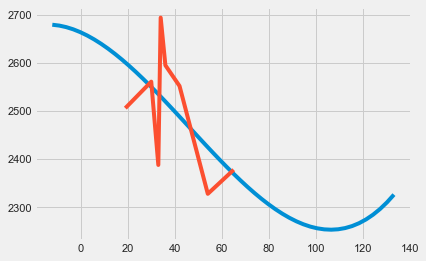

176.53231933575802 382.1567652865433


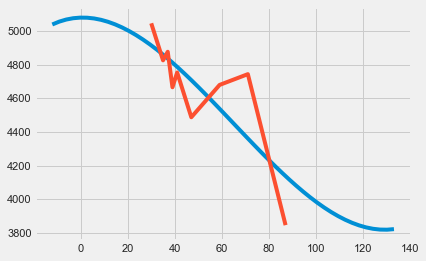

88.46673197470463 195.15329729550922


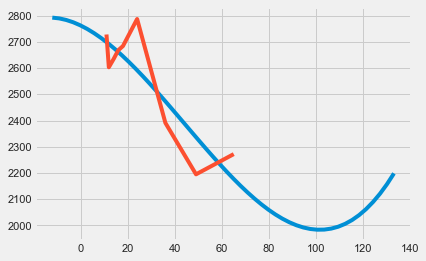

58.17603180954538 117.43784203566338


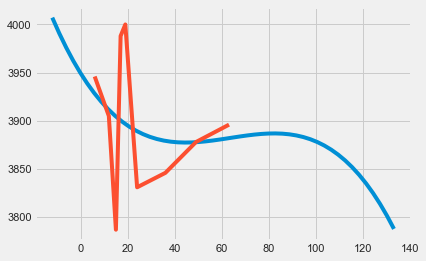

155.41643486210447 352.83483295664337


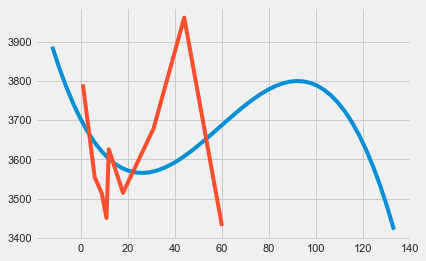

58.24859273602086 112.64693730730824


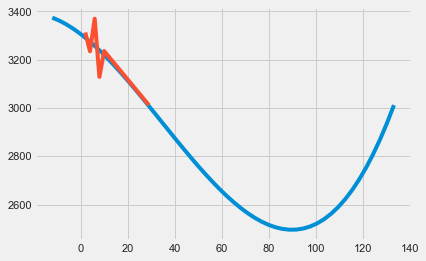

28.35448560141386 65.84366129522073


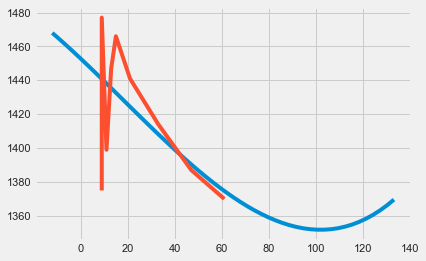

51.495823900122296 127.72892278567429


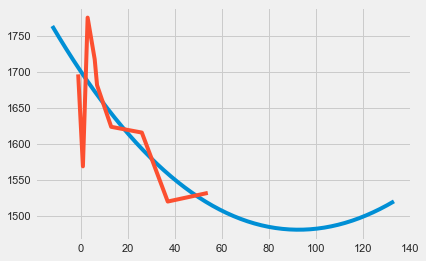

95.42603335364483 222.98975272023063


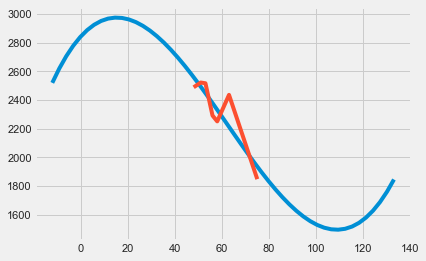

98.03946120132382 212.39339974319046


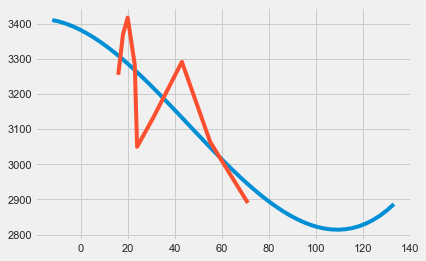

422.468881559838 1257.3506813265249


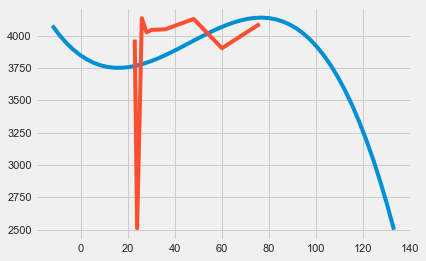

46.32414304464005 116.20780733565107


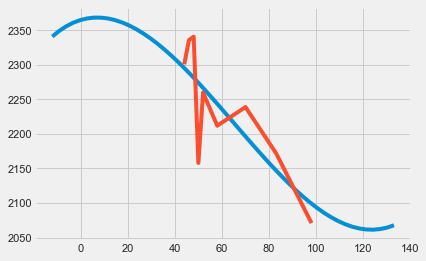

80.84009399865923 187.50006639818457


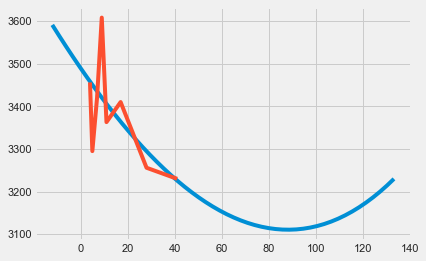

72.3359298006423 158.5585881992406


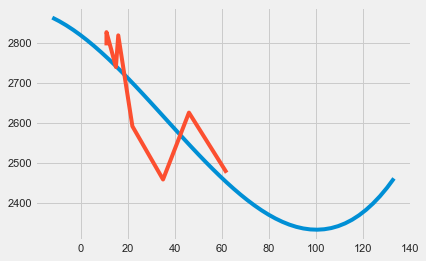

38.973064084726666 80.54451285936875


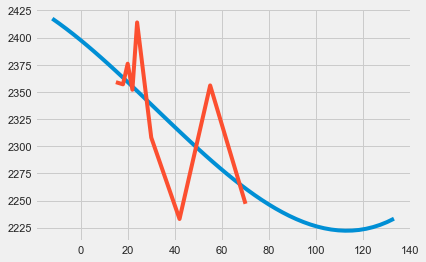

55.879165329746066 83.69135015439838


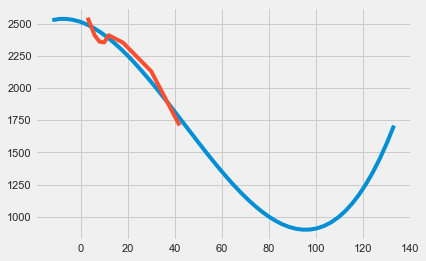

48.765893678598644 94.91533284083266


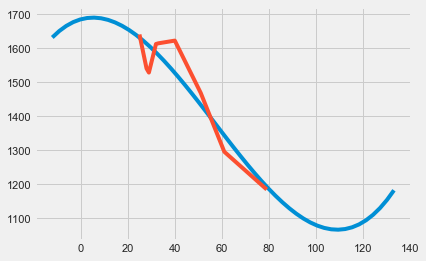

155.5363032132898 243.94869800808465


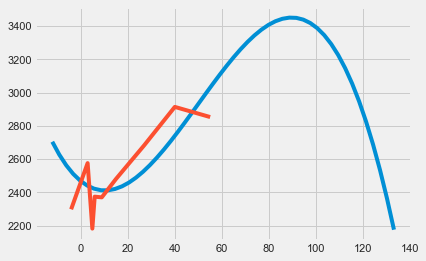

105.14850706818685 183.1490196232412


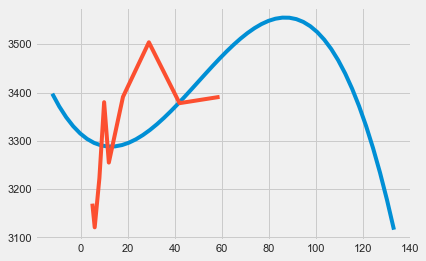

50.85312206137654 102.13420321971603


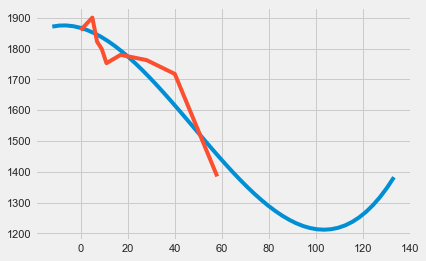

42.0421724669617 76.87114993624846


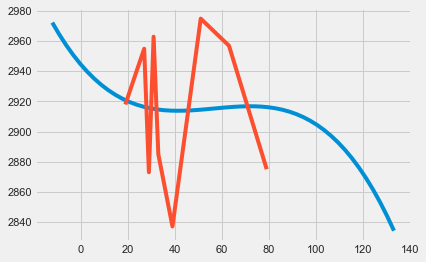

105.08617913645118 264.8013641234975


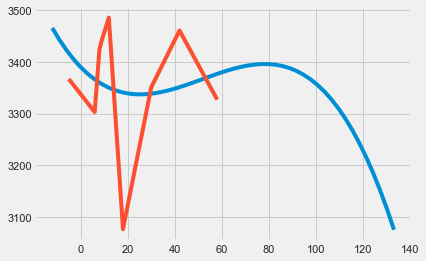

76.41345778121462 125.67677490153983


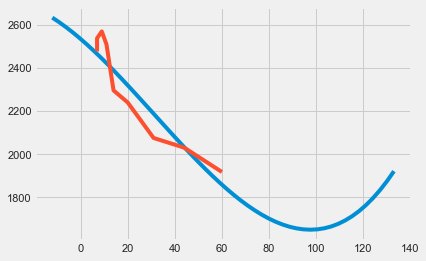

145.34410126153202 401.9493213470705


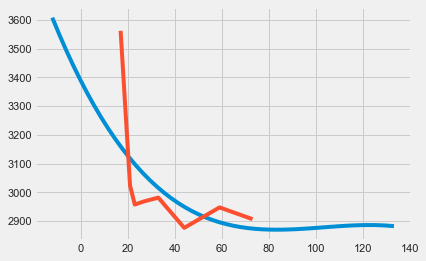

270.94398545295985 742.4408473631811


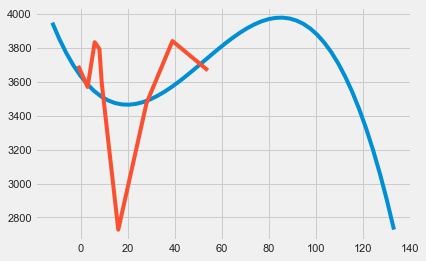

61.29483771054352 117.69040862931706


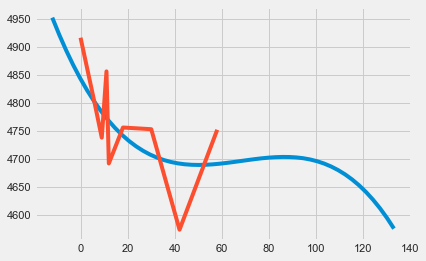

85.29136235135627 128.8880700134805


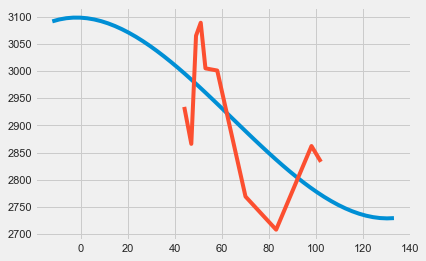

200.93360818666113 528.4591819071265


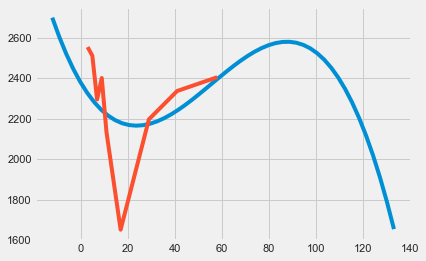

50.15997804277595 97.02705830985087


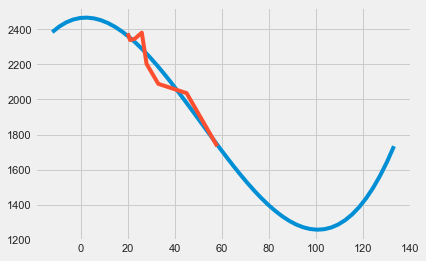

57.570714208479345 109.78656623329152


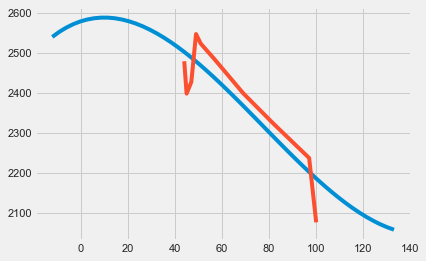

57.25972057102325 101.26178122921465


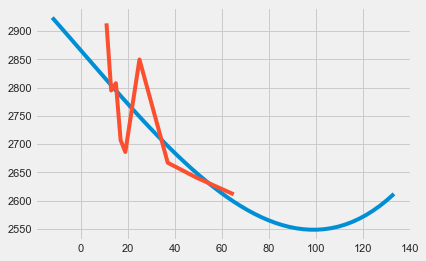

109.84702755951785 223.9693259981375


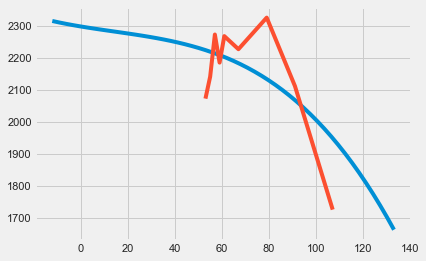

179.81703232451642 313.0020511484922


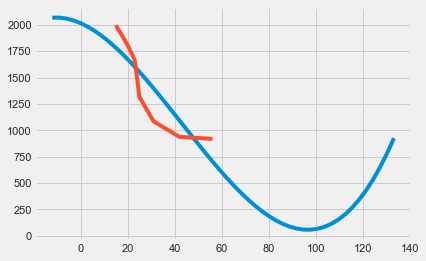

55.11343541930745 135.03769079098402


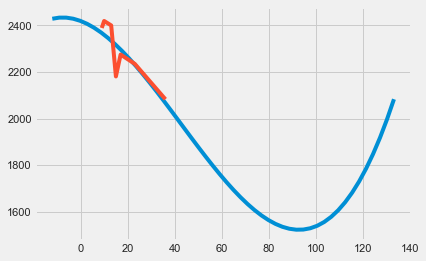

122.7729778958431 235.13385602908284


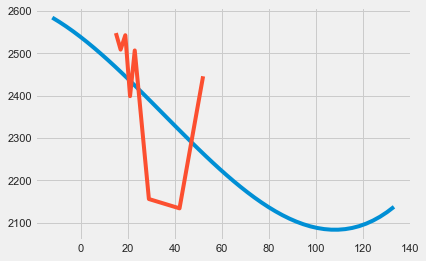

59.33790409561825 113.30232265540099


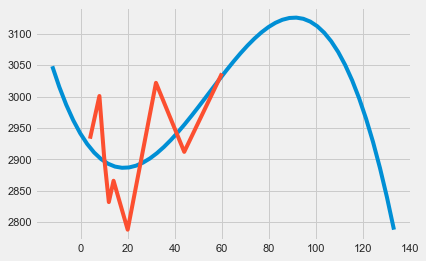

36.33171813236944 66.67923885128948


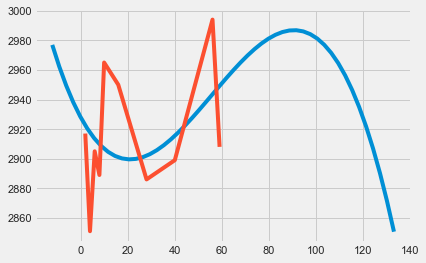

37.39241060531393 66.84330130740682


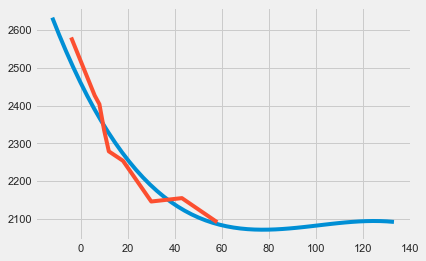

83.14235649583064 139.70793675238042


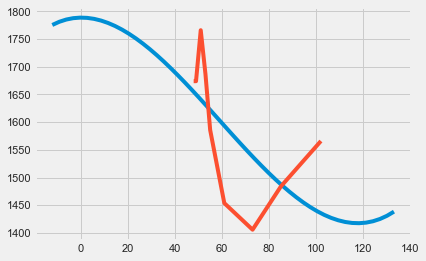

67.16229204317948 137.77882829283953


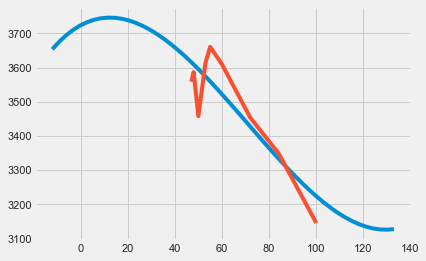

76.23027141602796 191.76715039659575


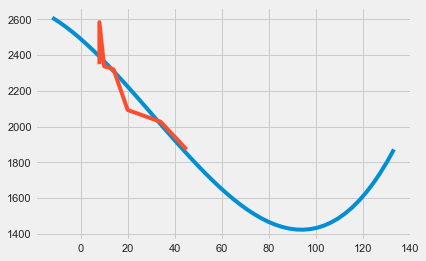

41.32436773240512 88.81563031421001


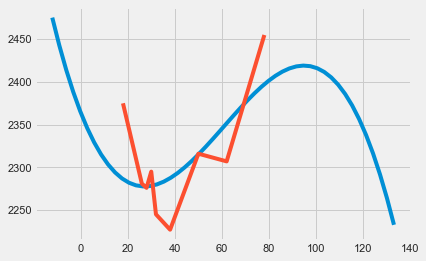

41.63910550314015 72.97522690004416


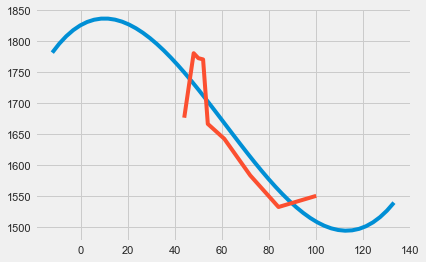

31.321999561443956 55.63976753779252


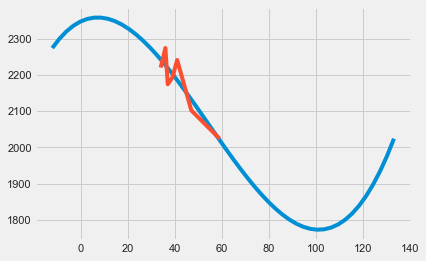

44.71956608803195 92.56656955261906


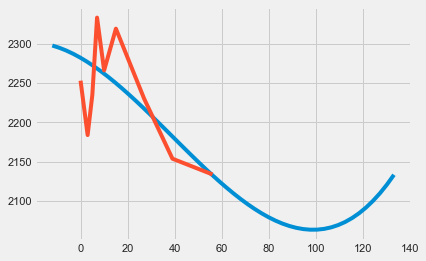

44.38277023836426 89.19399146058208


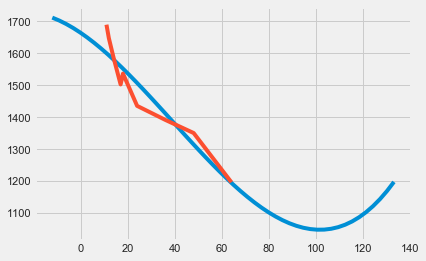

48.02732712761925 77.37492511235223


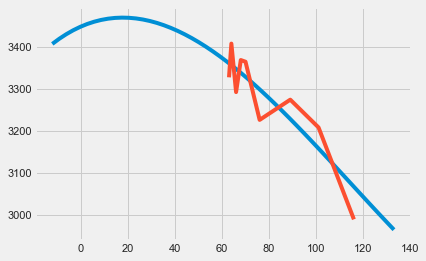

46.06229568906633 108.04725806066335


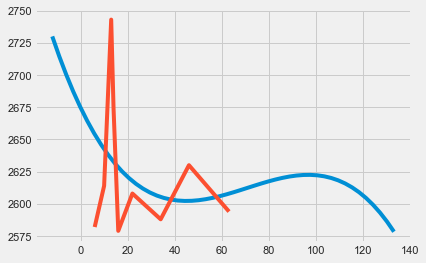

27.551991655919576 49.19159546781839


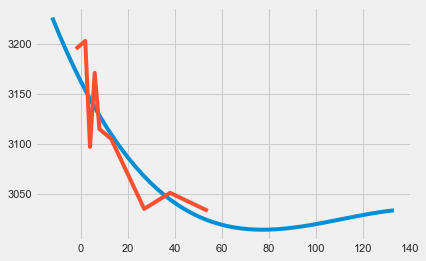

82.77330042006689 181.16447807078475


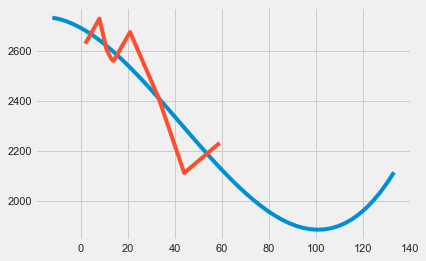

82.61701461606394 165.80532304659664


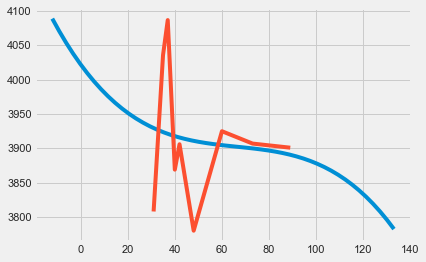

53.45758072982123 96.28206650447692


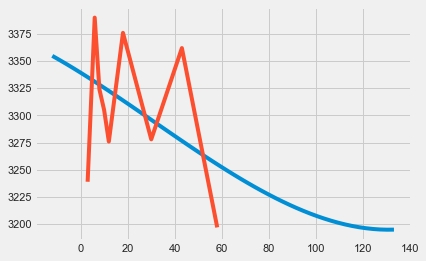

67.43670272060865 120.3562451688631


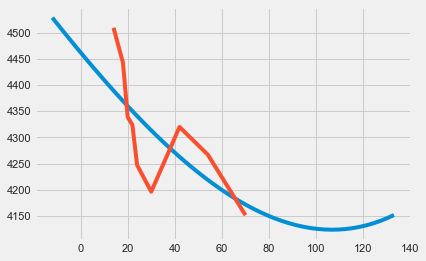

138.10009003561484 228.1777085507547


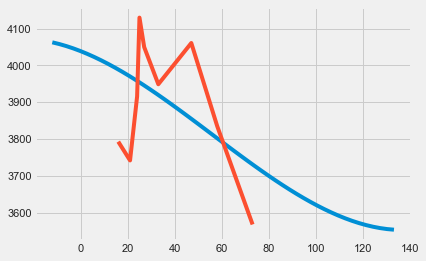

91.78059093443022 150.81244840001955


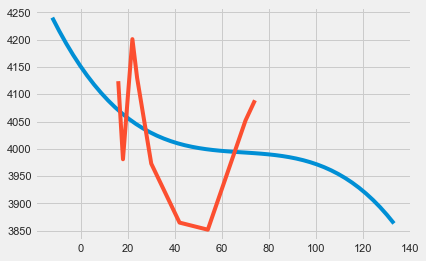

65.16908929458245 145.1055281627414


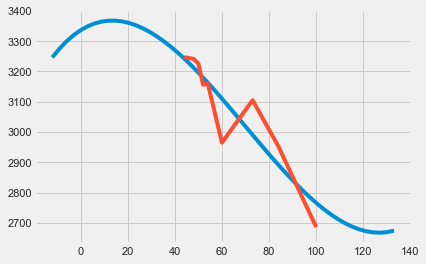

68.65632401123582 140.52262628052313


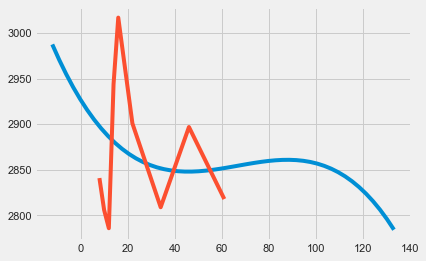

51.60969079939033 93.11650709065907


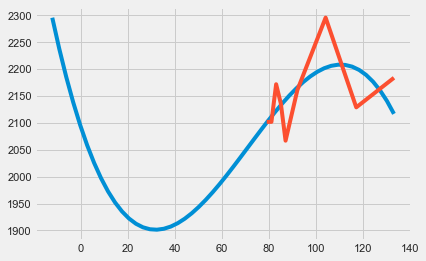

126.33375780096763 285.44423503058897


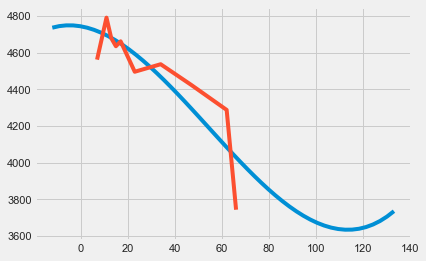

43.82978702781976 84.66968165215849


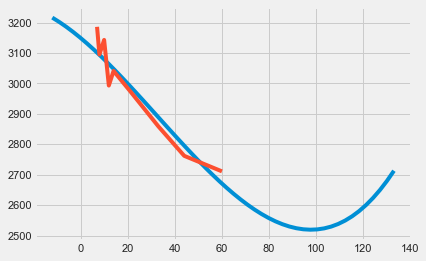

42.93782426192844 80.2482992842647


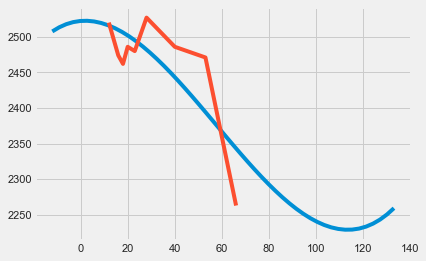

127.97430028218598 336.5551615200784


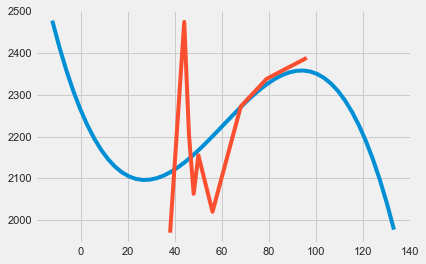

68.42917713574451 147.02970862524944


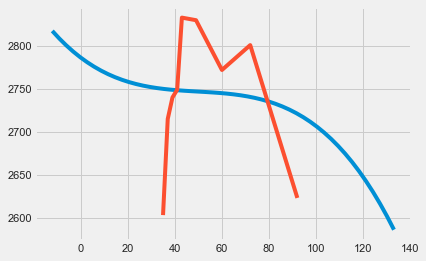

74.25544986118548 164.09678245002442


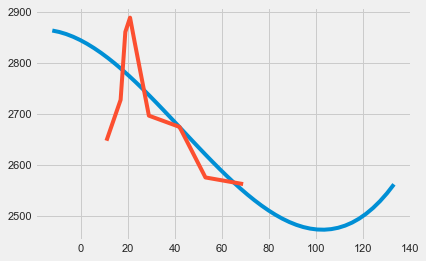

61.6642509519043 99.79797106408387


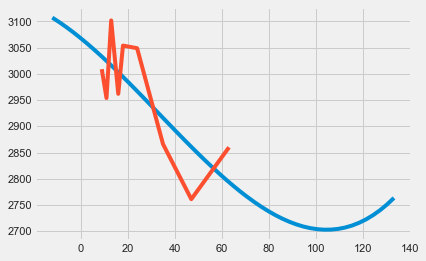

62.682806236505975 120.63093612004468


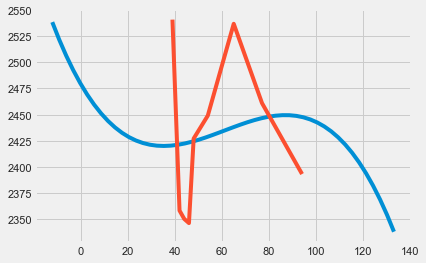

122.33917237102986 287.76805821281323


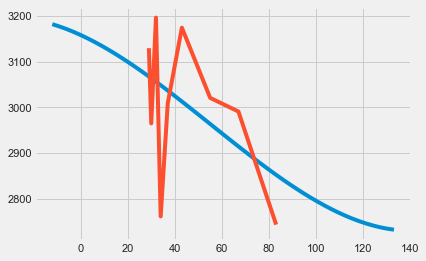

112.62804984743359 246.00405350050823


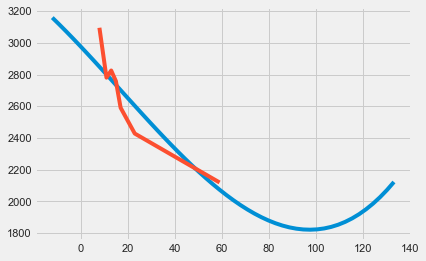

97.08152191041091 144.06851125787125


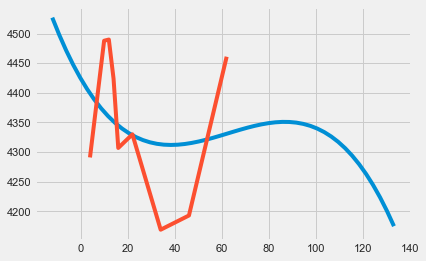

63.71900947315139 145.91399034473307


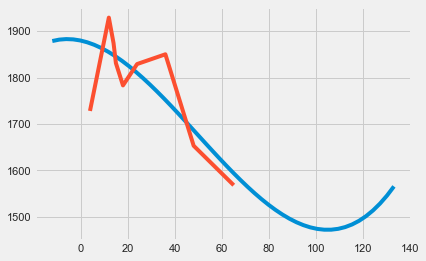

163.1029959859119 472.03753556429


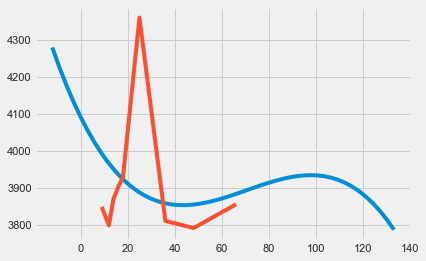

364.09626375603756 982.9386170562898


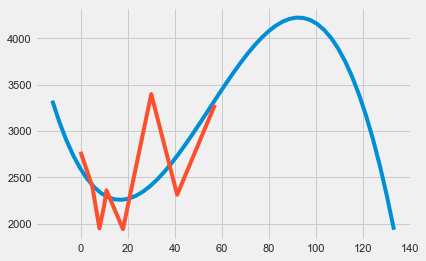

89.1084845304449 149.23714294564707


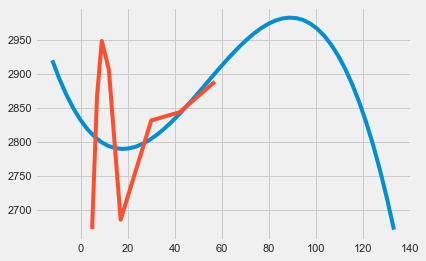

79.72483580118256 152.7483118300379


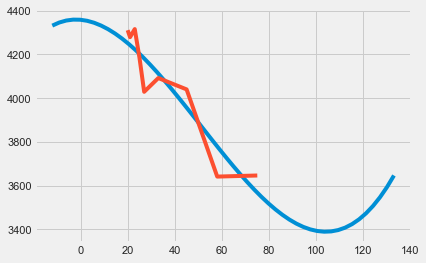

137.66149646257435 367.07693245940163


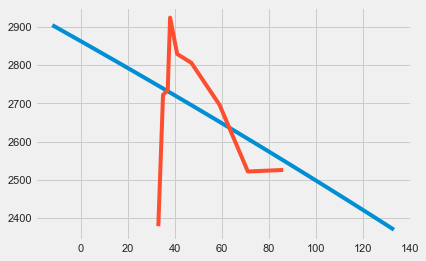

24.748289786014006 48.24235281015126


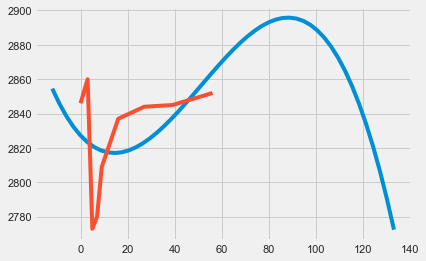

115.32355030496777 206.33213920249182


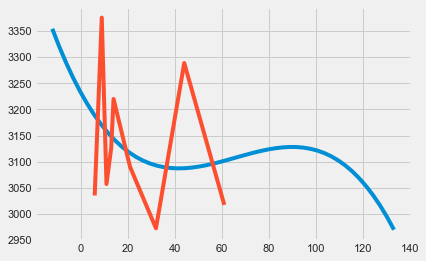

25.85160548305817 41.80383210401078


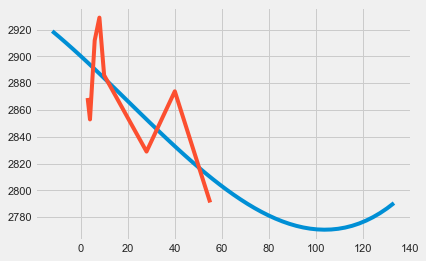

165.60208914488956 348.9945283118568


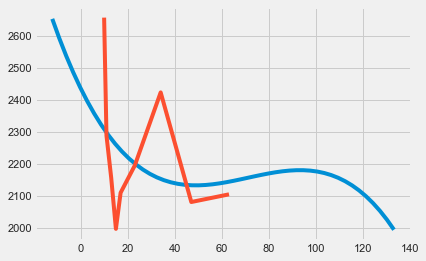

109.33194080524913 251.5036271926583


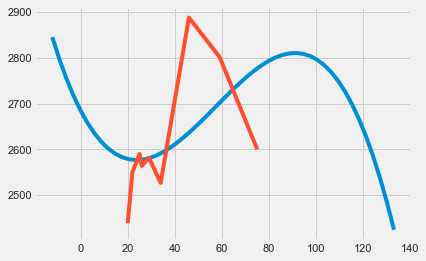

156.71368681131534 356.30051445543904


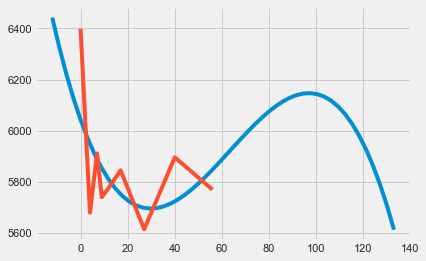

49.85647458121102 103.44322657973271


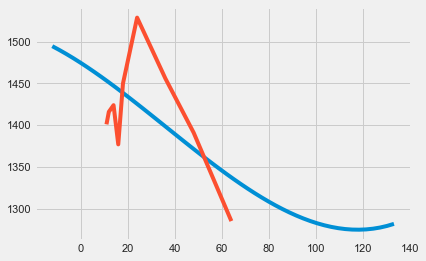

72.83554674282415 189.48998836230749


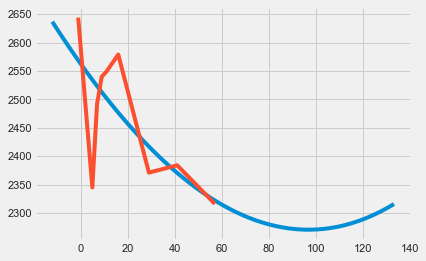

108.19335515495133 226.98661238335944


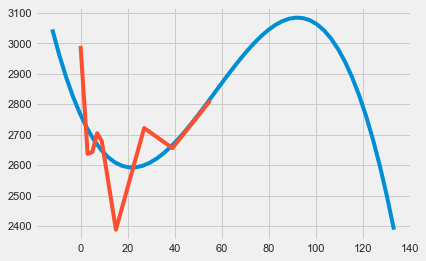

142.5284172000348 403.1922333664172


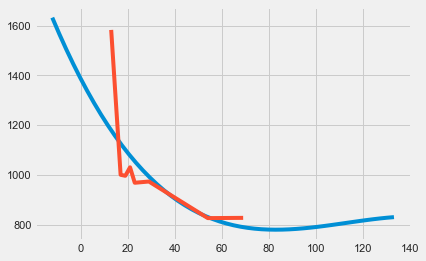

59.81972060784033 140.6423584233612


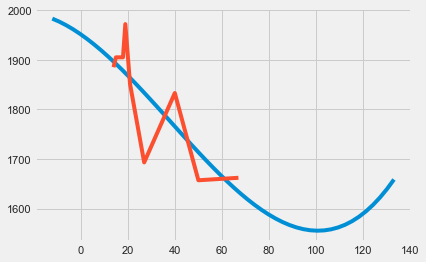

62.29489404206812 143.50258641884602


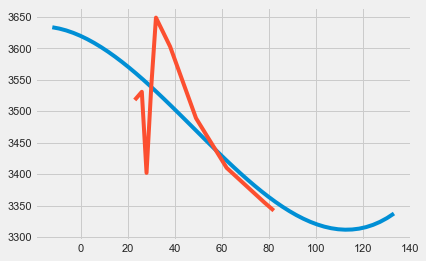

107.95265544071813 224.81433172610423


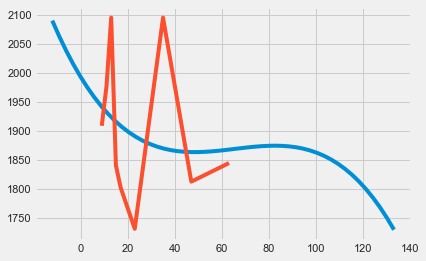

107.76499229387082 189.7007037895969


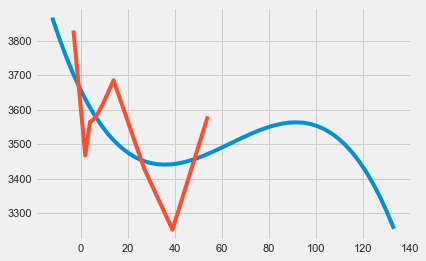

97.21648375586577 171.86387036647739


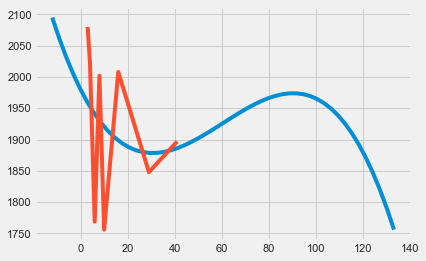

28.56258546245685 53.16282900676515


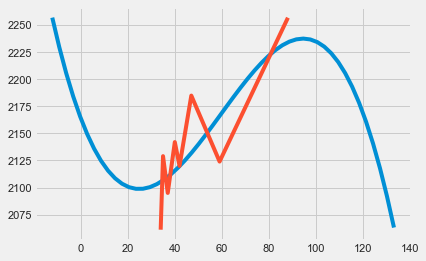

106.77733656988718 229.29375282882484


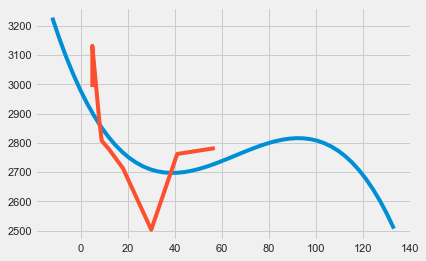

16.405636707057557 27.924515702095732


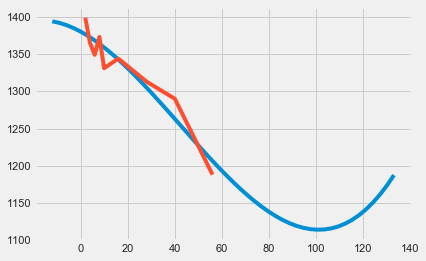

68.07403170216351 119.46360961023402


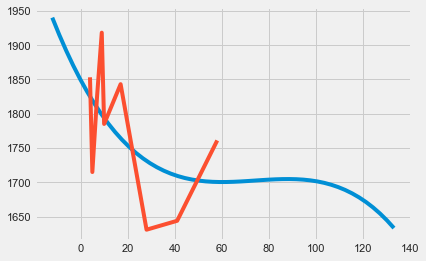

58.33194815833494 126.60974623828497


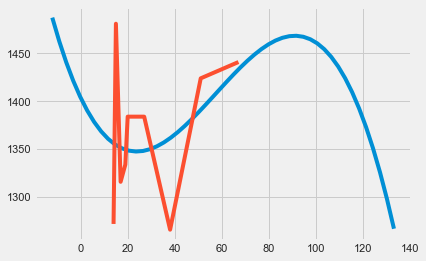

123.02285508708064 201.5963671808022


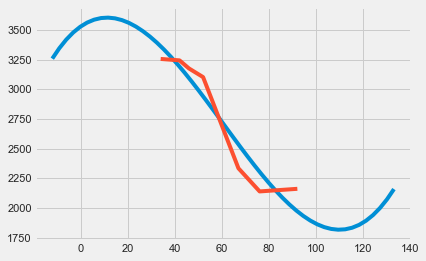

63.007021018321744 135.62831265371256


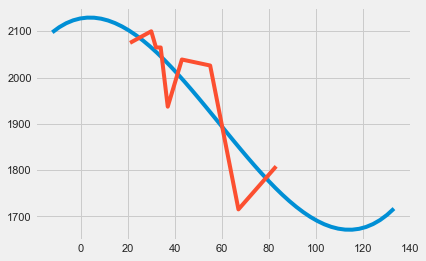

83.11028742391318 126.50738337187477


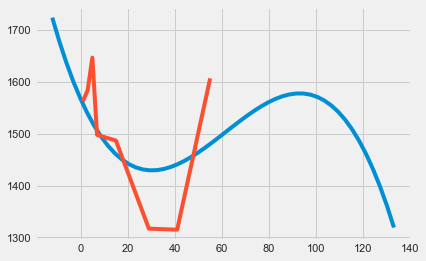

84.82639792569665 214.09605389721287


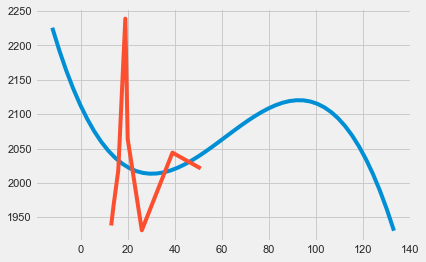

27.203289542493128 55.91396084754956


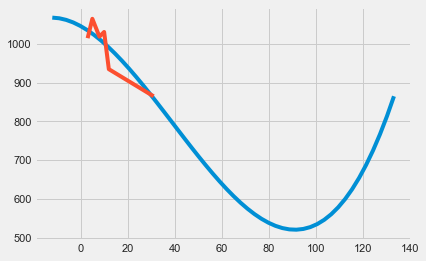

63.67415558723229 139.86398236341847


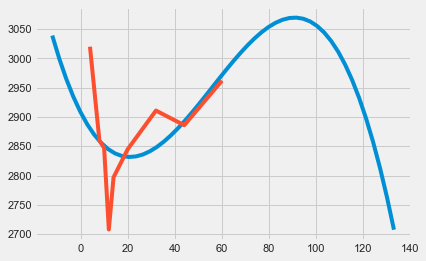

108.37457608344852 223.80178676883565


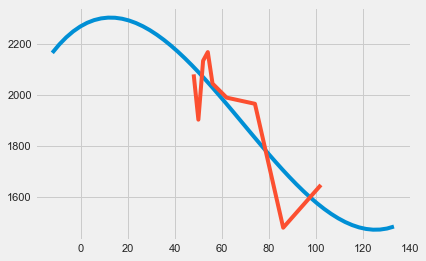

83.75936335068985 148.09801761707195


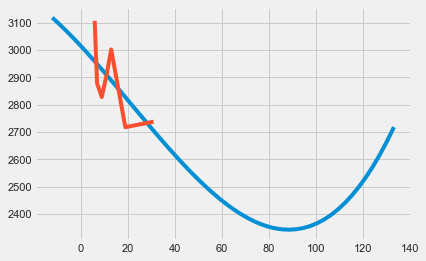

45.974336531644326 100.48325532121999


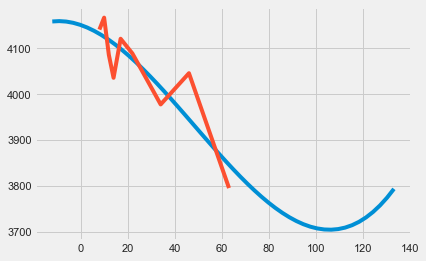

62.93816148088514 145.55358088839625


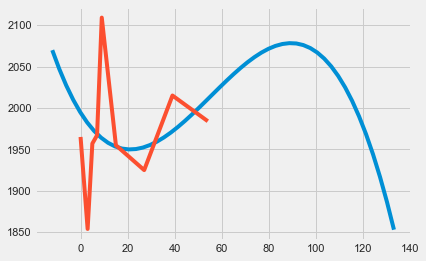

80.54273149076883 153.50628703010216


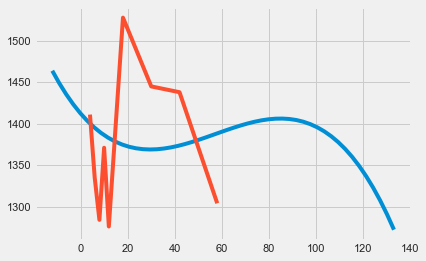

99.65782909545172 165.73344780877778


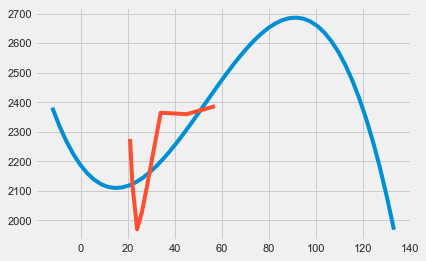

79.29418954866306 129.3694904574545


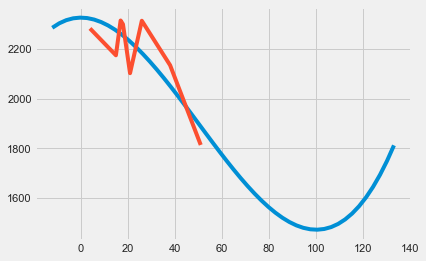

65.72517444022925 139.82508829148765


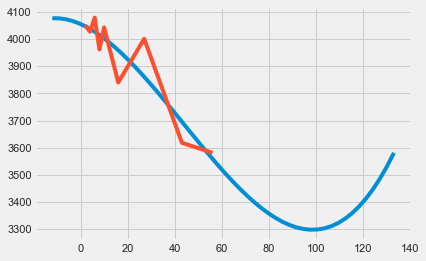

61.84728849184836 128.74139786862224


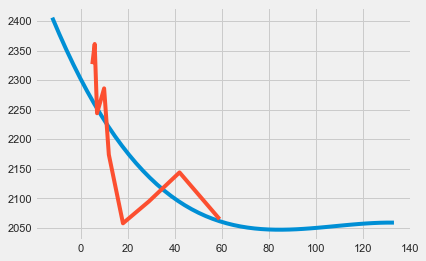

66.87356355109397 147.63902809974752


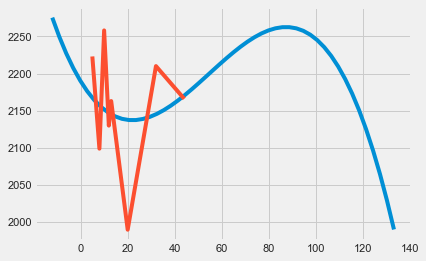

51.84640754600824 116.60296342248921


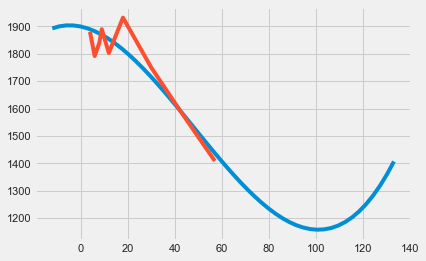

150.57227205669403 388.9080017401752


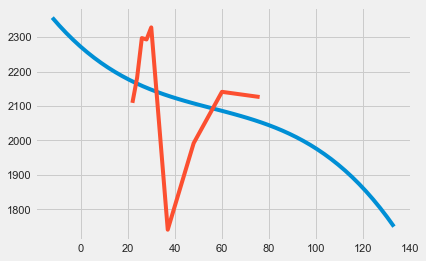

88.8761691432356 181.755740976364


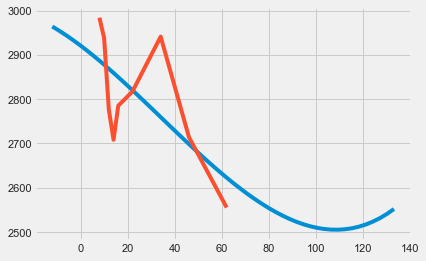

79.02430022001296 142.108779155084


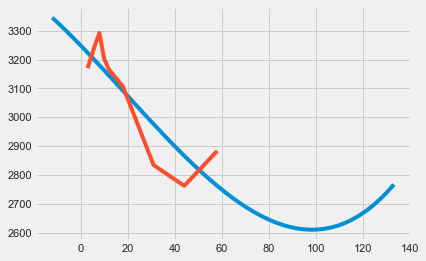

134.33590571095297 342.67072254352297


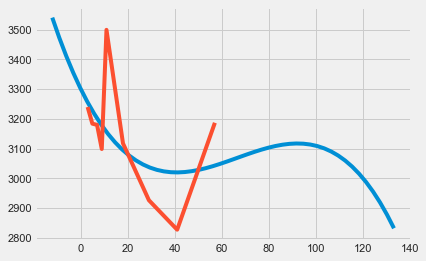

56.378787896147905 138.41472691144668


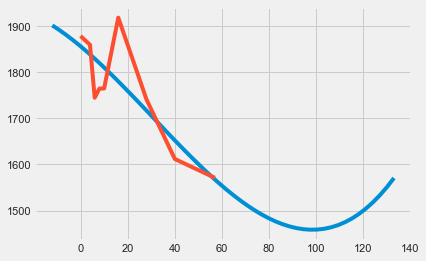

97.66465449704532 245.73142642613175


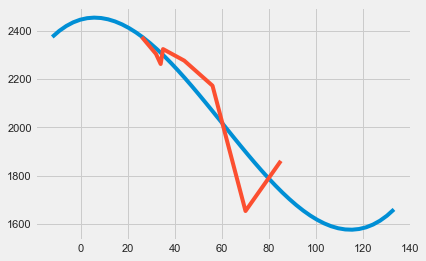

348.1307016907095 1049.563857686233


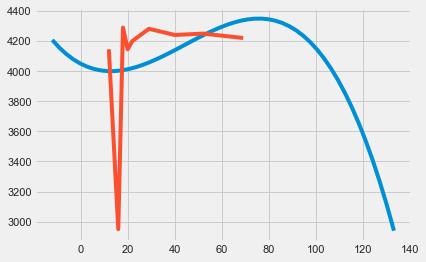

92.9307201634176 238.18248501436256


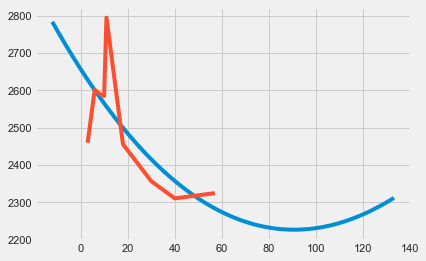

99.57834666523625 212.0175072279378


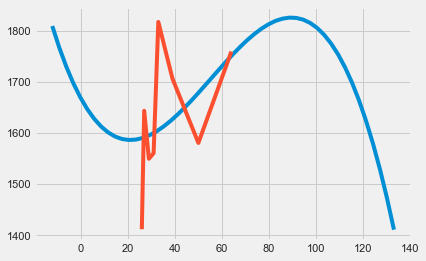

103.14912221662138 255.2662021787528


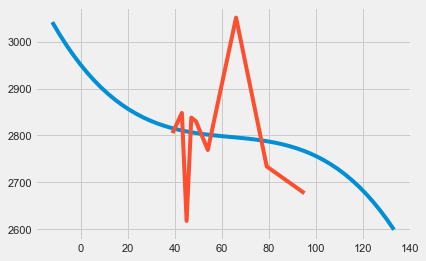

80.75440294712166 154.88983654075219


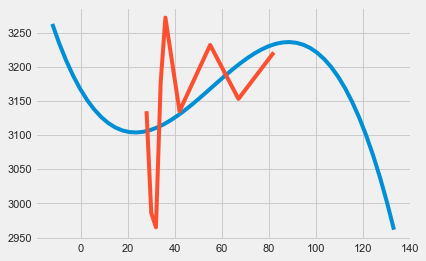

108.09211962708476 278.8117375762713


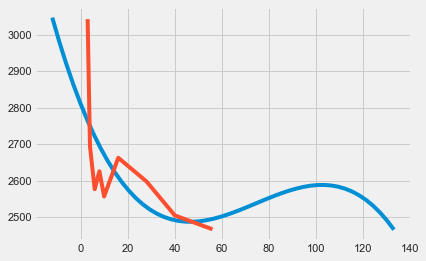

29.978730925069353 70.01576481660732


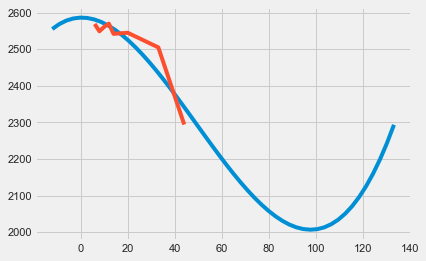

114.55117475065619 290.530871645341


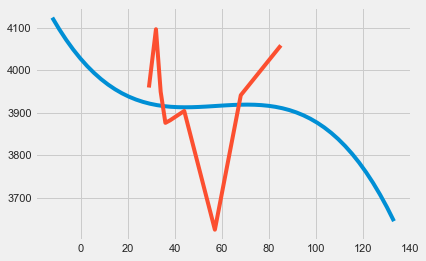

45.04785260138855 85.293880861238


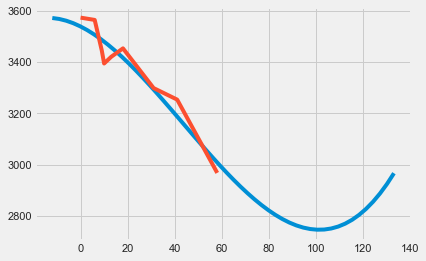

62.70632395632528 151.2978410861415


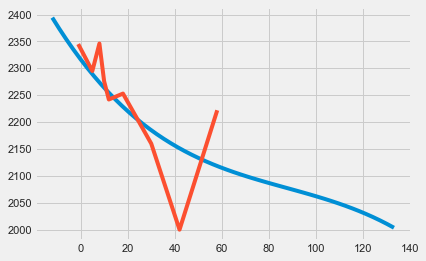

37.97469097469358 64.8384112167837


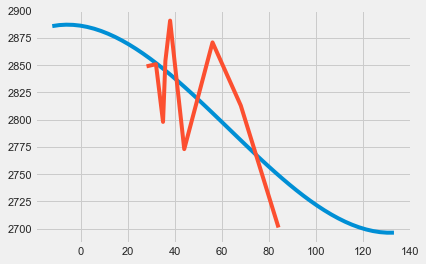

97.81345939356034 154.45711562099632


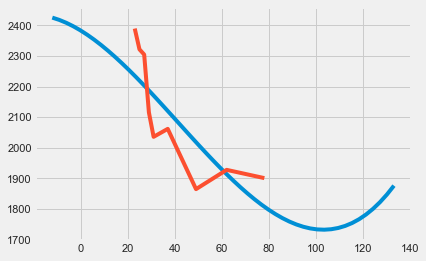

75.34238545365946 156.03296989596015


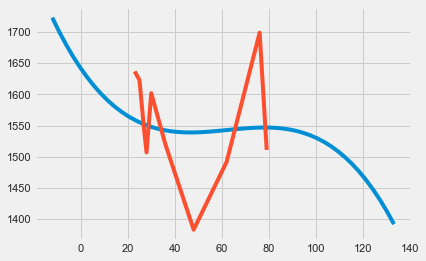

15.828914682969419 34.66651781889732


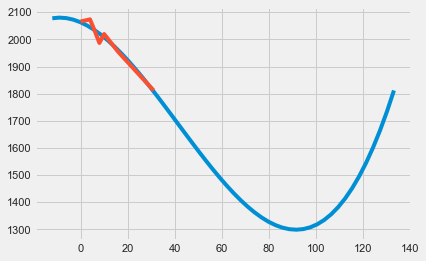

111.30261136695758 201.39748523056642


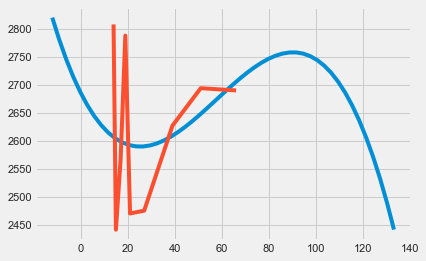

258.17452788325215 675.9274320120221


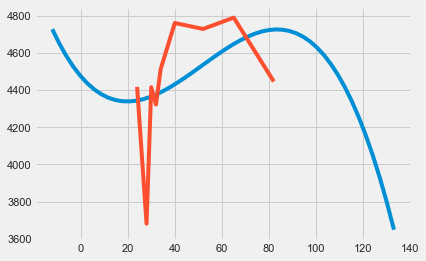

81.02804809642396 178.04923385451048


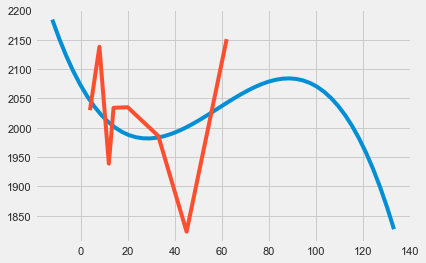

102.9610477294292 197.28391167893187


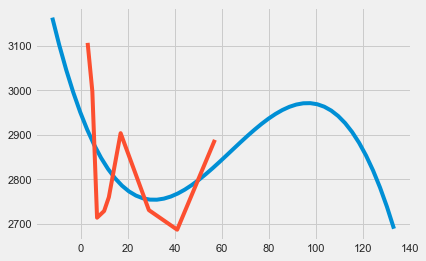

144.94196273668356 345.01160683155786


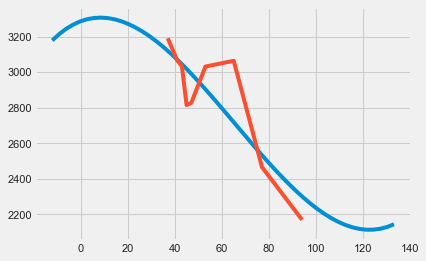

72.63210415998218 162.12841699799037


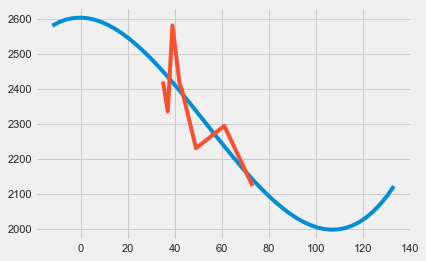

116.68075602440956 232.33763768067502


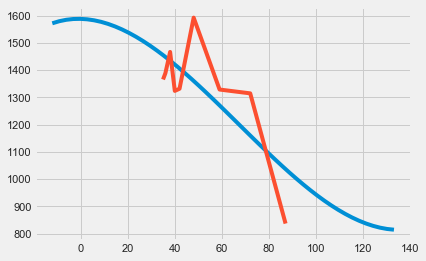

82.38651052319862 139.97349145612088


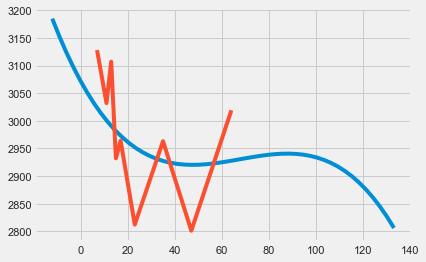

24.89960673828976 55.55977211306981


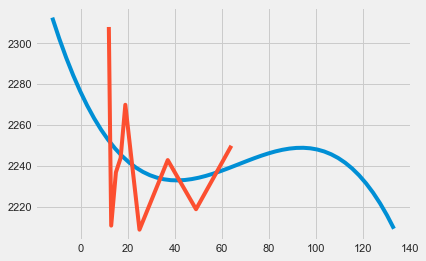

36.03192152901818 55.086619217142015


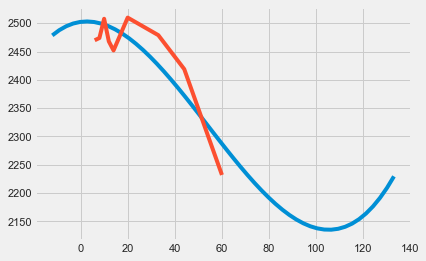

51.2227775805309 113.71858575239185


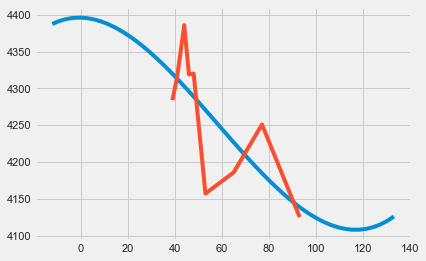

170.56978221063272 330.8637800451188


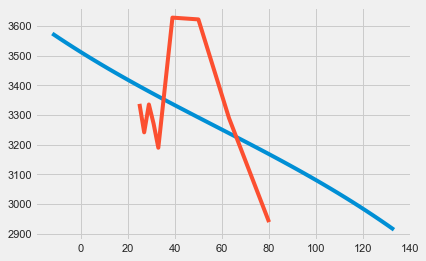

79.67934327604878 127.98978856157555


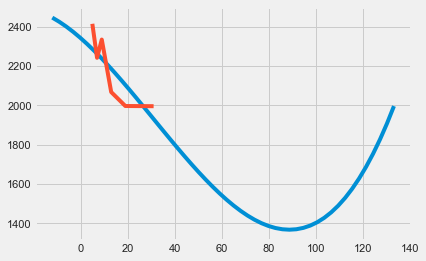

73.35367985898006 123.36094925752604


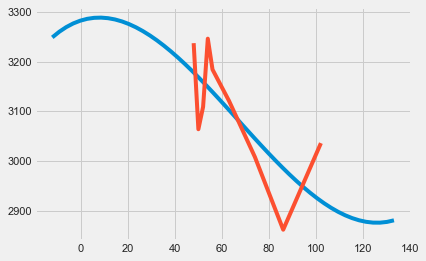

71.62676400590021 140.50394298355013


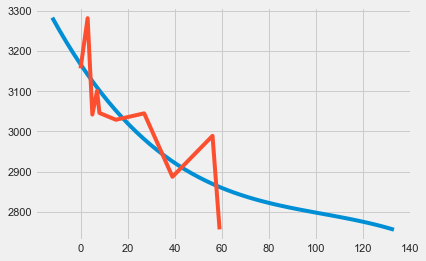

46.557276451552994 74.54088387144066


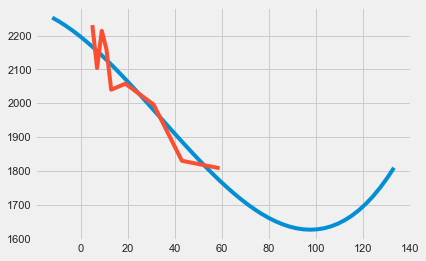

118.81347720328316 220.032809933698


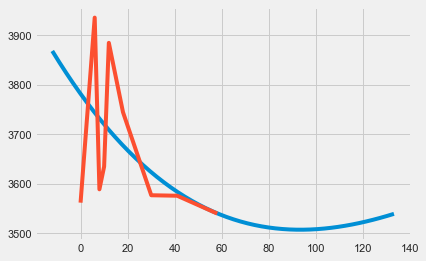

87.38547455247578 166.6781385813929


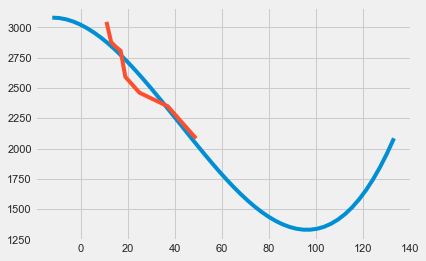

56.42979345176523 102.38521286323476


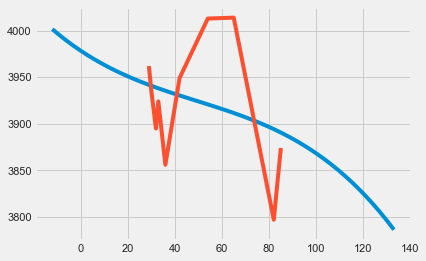

117.88912353305956 270.5962598803185


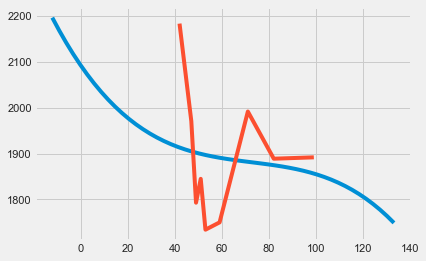

46.21065459993681 93.81905958625521


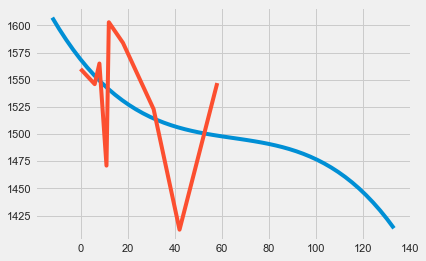

46.91693527493339 112.0116003946373


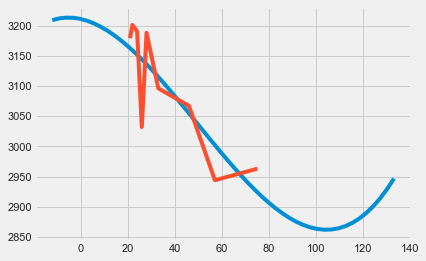

106.67663553124068 229.5541754321198


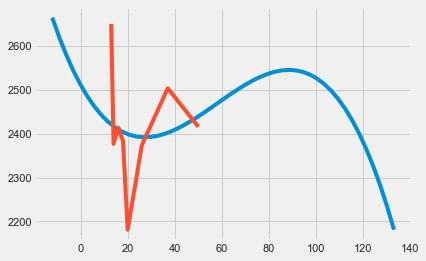

77.48634458012933 195.26857503910537


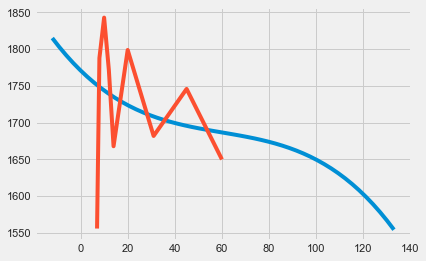

150.58005751322628 271.7999000137097


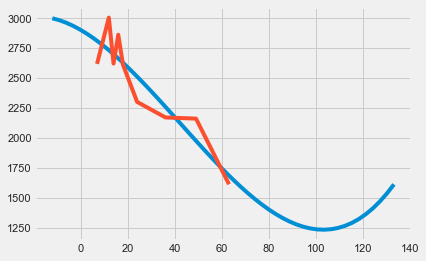

40.14065465517492 65.41417355220938


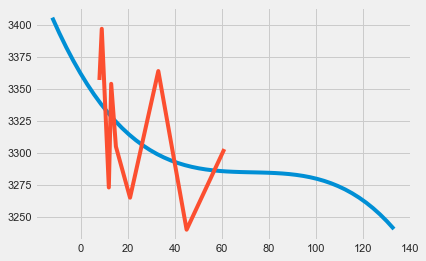

71.64491422759626 185.67719681736435


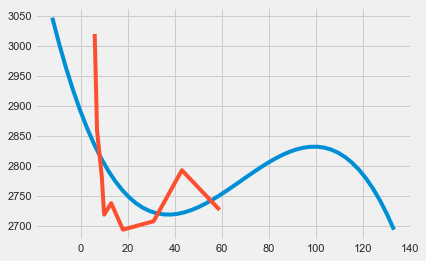

49.542905811737704 79.53799332882772


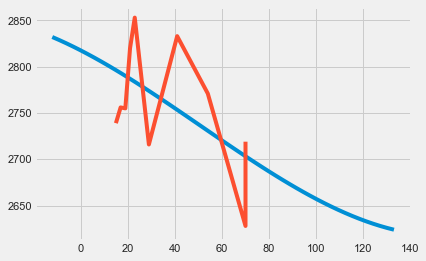

36.087398018217065 72.92736931234617


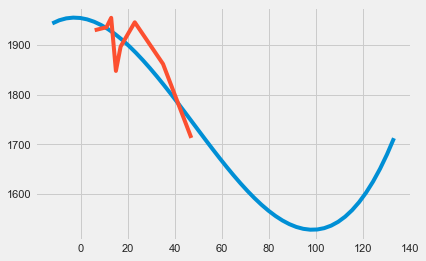

In [60]:
for i in range(174):
    x, y, poly = plot_n_deg_polynom_for_patient_with_hack(i, 3)
    std = np.std(poly(x) - y)
    L_inf = np.max(np.abs(poly(x) - y))
    print(std, L_inf)
    plt.show()

Person never smoked has FVC lower than smoker. Some Ex-smoker have very high FVC.

## Percent

A computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics

In [41]:
train_df['Percent'].value_counts()

83.282505     2
86.559510     2
121.595445    2
80.474296     2
61.885639     2
             ..
82.589902     1
65.508606     1
52.391737     1
54.591498     1
52.749977     1
Name: Percent, Length: 1536, dtype: int64

In [42]:
train_df['Percent'].iplot(kind='hist',bins=30,color='blue',xTitle='Percent distribution',yTitle='Count')

### Percent vs SmokingStatus In Patient Dataframe

In [43]:
df = train_df
fig = px.violin(df, y='Percent', x='SmokingStatus', box=True, color='Sex', points="all",
          hover_data=train_df.columns)
fig.show()

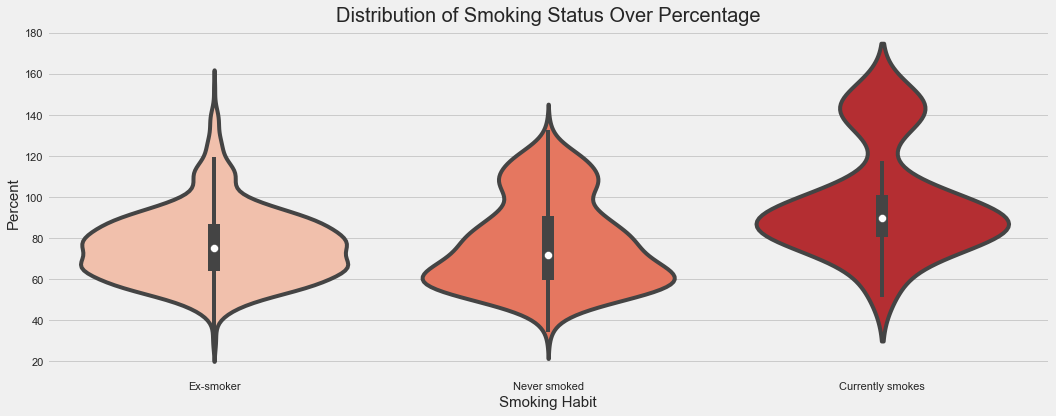

In [39]:
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x = train_df['SmokingStatus'], y = train_df['Percent'], palette = 'Reds')
ax.set_xlabel(xlabel = 'Smoking Habit', fontsize = 15)
ax.set_ylabel(ylabel = 'Percent', fontsize = 15)
ax.set_title(label = 'Distribution of Smoking Status Over Percentage', fontsize = 20)
plt.show()

In [40]:
fig = px.scatter(train_df, x="Age", y="Percent", color='SmokingStatus')
fig.show()

### Pick one patient for FVC vs Weeks

In [41]:
patient = train_df[train_df.Patient == 'ID00228637202259965313869']
fig = px.line(patient, x="Weeks", y="Percent", color='SmokingStatus')
fig.show()

In [46]:
patient = train_df[train_df.Patient == tmp_patients[0]]
fig = px.line(patient, x="Weeks", y="Percent", color='SmokingStatus')
fig.show()

## Age Distribution of Unique Patients

In [ ]:
patient_df['Age'].iplot(kind='hist',bins=30,color='red',xTitle='Ages of distribution',yTitle='Count')

### Distribution of Age vs SmokingStatus In Patient Dataframe

In [ ]:
patient_df['SmokingStatus'].value_counts()

In [ ]:
plt.figure(figsize=(16, 6))
sns.kdeplot(patient_df.loc[patient_df['SmokingStatus'] == 'Ex-smoker', 'Age'], label = 'Ex-smoker',shade=True)
sns.kdeplot(patient_df.loc[patient_df['SmokingStatus'] == 'Never smoked', 'Age'], label = 'Never smoked',shade=True)
sns.kdeplot(patient_df.loc[patient_df['SmokingStatus'] == 'Currently smokes', 'Age'], label = 'Currently smokes', shade=True)

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.violinplot(x = patient_df['SmokingStatus'], y = patient_df['Age'], palette = 'Reds')
ax.set_xlabel(xlabel = 'Smoking habit', fontsize = 15)
ax.set_ylabel(ylabel = 'Age', fontsize = 15)
ax.set_title(label = 'Distribution of Smokers over Age', fontsize = 20)
plt.show()

### Distribution of Age vs Gender In Patient Dataframe

In [ ]:
plt.figure(figsize=(16, 6))
sns.kdeplot(patient_df.loc[patient_df['Sex'] == 'Male', 'Age'], label = 'Male',shade=True)
sns.kdeplot(patient_df.loc[patient_df['Sex'] == 'Female', 'Age'], label = 'Female',shade=True)
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

## Gender Distribution

In [ ]:
patient_df['Sex'].value_counts()

In [ ]:
patient_df['Sex'].value_counts().iplot(kind='bar',
                                          yTitle='Count', 
                                          linecolor='black', 
                                          opacity=0.7,
                                          color='blue',
                                          theme='pearl',
                                          bargap=0.8,
                                          gridcolor='white',
                                          title='Distribution of the Sex column in Patient Dataframe')

`139` : Male

`37` : Female

### Gender vs SmokingStatus In Patient Dataframe

In [ ]:
plt.figure(figsize=(16, 6))
a = sns.countplot(data=patient_df, x='SmokingStatus', hue='Sex')

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

plt.title('Gender split by SmokingStatus', fontsize=16)
sns.despine(left=True, bottom=True);

In [ ]:
fig = px.box(patient_df, x="Sex", y="Age", points="all")
fig.show()

## Patient Overlap

In [ ]:
# Extract patient id's for the training set
ids_train = train_df.Patient.values
# Extract patient id's for the validation set
ids_test = test_df.Patient.values
#print(Fore.YELLOW +"Total Patients in Train set: ",Style.RESET_ALL,train_df['Patient'].count())
# Create a "set" datastructure of the training set id's to identify unique id's
ids_train_set = set(ids_train)
print(Fore.YELLOW + "There are",Style.RESET_ALL,f'{len(ids_train_set)}', Fore.BLUE + 'unique Patient IDs',Style.RESET_ALL,'in the training set')
# Create a "set" datastructure of the validation set id's to identify unique id's
ids_test_set = set(ids_test)
print(Fore.YELLOW + "There are", Style.RESET_ALL, f'{len(ids_test_set)}', Fore.BLUE + 'unique Patient IDs',Style.RESET_ALL,'in the test set')

# Identify patient overlap by looking at the intersection between the sets
patient_overlap = list(ids_train_set.intersection(ids_test_set))
n_overlap = len(patient_overlap)
print(Fore.YELLOW + "There are", Style.RESET_ALL, f'{n_overlap}', Fore.BLUE + 'Patient IDs',Style.RESET_ALL, 'in both the training and test sets')
print('')
print(Fore.CYAN + 'These patients are in both the training and test datasets:', Style.RESET_ALL)
print(f'{patient_overlap}')

`5` patients are in both the training and test datasets.

## Heatmap for train.csv

In [ ]:
corrmat = train_df.corr() 
f, ax = plt.subplots(figsize =(9, 8)) 
sns.heatmap(corrmat, ax = ax, cmap = 'RdYlBu_r', linewidths = 0.5) 

Please compare with the previous visualization information. And we may compare to Pandas Profiling below.

# 6. <a id='visual'>Visualising Images : DECOM 🗺️</a>  

`1` type of images containing the information:

- `.dcm` files: [DICOM files](https://en.wikipedia.org/wiki/DICOM). It's saved in the "Digital Imaging and Communications in Medicine" format. It contains an image from a medical scan, such as an ultrasound or MRI + information about the patient.

In [ ]:
print(Fore.YELLOW + 'Train .dcm number of images:',Style.RESET_ALL, len(list(os.listdir('../input/osic-pulmonary-fibrosis-progression/train'))), '\n' +
      Fore.BLUE + 'Test .dcm number of images:',Style.RESET_ALL, len(list(os.listdir('../input/osic-pulmonary-fibrosis-progression/test'))), '\n' +
      '--------------------------------', '\n' +
      'There is the same number of images as in train/ test .csv datasets')

Let's look at the DICOM images.

In [ ]:
def plot_pixel_array(dataset, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.grid(False)
    plt.imshow(dataset.pixel_array, cmap='gray') # cmap=plt.cm.bone)
    plt.show()

In [ ]:
# https://www.kaggle.com/schlerp/getting-to-know-dicom-and-the-data
def show_dcm_info(dataset):
    print(Fore.YELLOW + "Filename.........:",Style.RESET_ALL,file_path)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print(Fore.BLUE + "Patient's name......:",Style.RESET_ALL, display_name)
    print(Fore.BLUE + "Patient id..........:",Style.RESET_ALL, dataset.PatientID)
    print(Fore.BLUE + "Patient's Sex.......:",Style.RESET_ALL, dataset.PatientSex)
    print(Fore.YELLOW + "Modality............:",Style.RESET_ALL, dataset.Modality)
    print(Fore.GREEN + "Body Part Examined..:",Style.RESET_ALL, dataset.BodyPartExamined)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print(Fore.BLUE + "Image size.......:",Style.RESET_ALL," {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print(Fore.YELLOW + "Pixel spacing....:",Style.RESET_ALL,dataset.PixelSpacing)
            dataset.PixelSpacing = [1, 1]
        plt.figure(figsize=(10, 10))
        plt.imshow(dataset.pixel_array, cmap='gray')
        plt.show()
for file_path in glob.glob('../input/osic-pulmonary-fibrosis-progression/train/*/*.dcm'):
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    break # Comment this out to see all

In [ ]:
# https://www.kaggle.com/yeayates21/osic-simple-image-eda

imdir = "/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140"
print("total images for patient ID00123637202217151272140: ", len(os.listdir(imdir)))

# view first (columns*rows) images in order
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
imglist = os.listdir(imdir)
for i in range(1, columns*rows +1):
    filename = imdir + "/" + str(i) + ".dcm"
    ds = pydicom.dcmread(filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap='gray')
plt.show()

In [ ]:
# https://www.kaggle.com/yeayates21/osic-simple-image-eda

imdir = "/kaggle/input/osic-pulmonary-fibrosis-progression/train/ID00123637202217151272140"
print("total images for patient ID00123637202217151272140: ", len(os.listdir(imdir)))

# view first (columns*rows) images in order
fig=plt.figure(figsize=(12, 12))
columns = 4
rows = 5
imglist = os.listdir(imdir)
for i in range(1, columns*rows +1):
    filename = imdir + "/" + str(i) + ".dcm"
    ds = pydicom.dcmread(filename)
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap='jet')
plt.show()

# Visualization using gif
* https://www.kaggle.com/danpresil1/dicom-basic-preprocessing-and-visualization

In [ ]:
apply_resample = False

def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [ ]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [ ]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [ ]:
def set_lungwin(img, hu=[-1200., 600.]):
    lungwin = np.array(hu)
    newimg = (img-lungwin[0]) / (lungwin[1]-lungwin[0])
    newimg[newimg < 0] = 0
    newimg[newimg > 1] = 1
    newimg = (newimg * 255).astype('uint8')
    return newimg

In [ ]:
scans = load_scan('../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/')
scan_array = set_lungwin(get_pixels_hu(scans))

In [ ]:
# Resample to 1mm (An optional step, it may not be relevant to this competition because of the large slice thickness on the z axis)

from scipy.ndimage.interpolation import zoom

def resample(imgs, spacing, new_spacing):
    new_shape = np.round(imgs.shape * spacing / new_spacing)
    true_spacing = spacing * imgs.shape / new_shape
    resize_factor = new_shape / imgs.shape
    imgs = zoom(imgs, resize_factor, mode='nearest')
    return imgs, true_spacing, new_shape

spacing_z = (scans[-1].ImagePositionPatient[2] - scans[0].ImagePositionPatient[2]) / len(scans)

if apply_resample:
    scan_array_resample = resample(scan_array, np.array(np.array([spacing_z, *scans[0].PixelSpacing])), np.array([1.,1.,1.]))[0]

In [ ]:
import imageio
from IPython.display import Image

imageio.mimsave("/tmp/gif.gif", scan_array, duration=0.0001)
Image(filename="/tmp/gif.gif", format='png')

# Visualization using Animation
* https://www.kaggle.com/pranavkasela/animating-the-lung-ct-scan

For animation, I used scan_array in 'visualization using gif' section.

In [ ]:
import matplotlib.animation as animation

fig = plt.figure()

ims = []
for image in scan_array:
    im = plt.imshow(image, animated=True, cmap="Greys")
    plt.axis("off")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=False,
                                repeat_delay=1000)


In [ ]:
HTML(ani.to_jshtml())

In [ ]:
HTML(ani.to_html5_video())

# 7. <a id='extract'>Extracting DIOCOM files information in a dataframe 🌊</a>

* https://www.kaggle.com/trsekhar123/nb-to-extract-metadata-and-resize-images-train

In [ ]:
def extract_dicom_meta_data(filename: str) -> Dict:
    # Load image
    
    image_data = pydicom.read_file(filename)
    img=np.array(image_data.pixel_array).flatten()
    row = {
        'Patient': image_data.PatientID,
        'body_part_examined': image_data.BodyPartExamined,
        'image_position_patient': image_data.ImagePositionPatient,
        'image_orientation_patient': image_data.ImageOrientationPatient,
        'photometric_interpretation': image_data.PhotometricInterpretation,
        'rows': image_data.Rows,
        'columns': image_data.Columns,
        'pixel_spacing': image_data.PixelSpacing,
        'window_center': image_data.WindowCenter,
        'window_width': image_data.WindowWidth,
        'modality': image_data.Modality,
        'StudyInstanceUID': image_data.StudyInstanceUID,
        'SeriesInstanceUID': image_data.StudyInstanceUID,
        'StudyID': image_data.StudyInstanceUID, 
        'SamplesPerPixel': image_data.SamplesPerPixel,
        'BitsAllocated': image_data.BitsAllocated,
        'BitsStored': image_data.BitsStored,
        'HighBit': image_data.HighBit,
        'PixelRepresentation': image_data.PixelRepresentation,
        'RescaleIntercept': image_data.RescaleIntercept,
        'RescaleSlope': image_data.RescaleSlope,
        'img_min': np.min(img),
        'img_max': np.max(img),
        'img_mean': np.mean(img),
        'img_std': np.std(img)}

    return row

In [ ]:
train_image_path = '/kaggle/input/osic-pulmonary-fibrosis-progression/train'
train_image_files = glob.glob(os.path.join(train_image_path, '*', '*.dcm'))

meta_data_df = []
for filename in tqdm.tqdm(train_image_files):
    try:
        meta_data_df.append(extract_dicom_meta_data(filename))
    except Exception as e:
        continue

The meta elements in dcom file seem to be slightly different for each file. So, I use Exception.
- Be careful!

In [ ]:
# Convert to a pd.DataFrame from dict
meta_data_df = pd.DataFrame.from_dict(meta_data_df)
meta_data_df.head()

The code below still makes sense, so I leave it.

In [ ]:
# source: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/154658
folder='train'
PATH='../input/osic-pulmonary-fibrosis-progression/'

last_index = 2

column_names = ['image_name', 'dcm_ImageOrientationPatient', 
                'dcm_ImagePositionPatient', 'dcm_PatientID',
                'dcm_PatientName', 'dcm_PatientSex'
                'dcm_rows', 'dcm_columns']

def extract_DICOM_attributes(folder):
    patients_folder = list(os.listdir(os.path.join(PATH, folder)))
    df = pd.DataFrame()
    
    i = 0
    
    for patient_id in patients_folder:
   
        img_path = os.path.join(PATH, folder, patient_id)
        
        print(img_path)
        
        images = list(os.listdir(img_path))
        
        #df = pd.DataFrame()

        for image in images:
            image_name = image.split(".")[0]

            dicom_file_path = os.path.join(img_path,image)
            dicom_file_dataset = pydicom.read_file(dicom_file_path)
                
            '''
            print(dicom_file_dataset.dir("pat"))
            print(dicom_file_dataset.data_element("ImageOrientationPatient"))
            print(dicom_file_dataset.data_element("ImagePositionPatient"))
            print(dicom_file_dataset.data_element("PatientID"))
            print(dicom_file_dataset.data_element("PatientName"))
            print(dicom_file_dataset.data_element("PatientSex"))
            '''
            
            imageOrientationPatient = dicom_file_dataset.ImageOrientationPatient
            #imagePositionPatient = dicom_file_dataset.ImagePositionPatient
            patientID = dicom_file_dataset.PatientID
            patientName = dicom_file_dataset.PatientName
            patientSex = dicom_file_dataset.PatientSex
        
            rows = dicom_file_dataset.Rows
            cols = dicom_file_dataset.Columns
            
            #print(rows)
            #print(columns)
            
            temp_dict = {'image_name': image_name, 
                                    'dcm_ImageOrientationPatient': imageOrientationPatient,
                                    #'dcm_ImagePositionPatient':imagePositionPatient,
                                    'dcm_PatientID': patientID, 
                                    'dcm_PatientName': patientName,
                                    'dcm_PatientSex': patientSex,
                                    'dcm_rows': rows,
                                    'dcm_columns': cols}


            df = df.append([temp_dict])
            
        i += 1
        
        if i == last_index:
            break
            
    return df


In [ ]:
extract_DICOM_attributes('train')

# <a id='etc'>Etc. - Pandas Profiling 🌤️</a>

The meta elements in dcom file seem to be slightly different for each file.
- Be careful!

In [ ]:
import pandas_profiling as pdp

In [ ]:
train_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv')
test_df = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')

In [ ]:
profile_train_df = pdp.ProfileReport(train_df)

In [ ]:
profile_train_df

In [ ]:
profile_test_df = pdp.ProfileReport(test_df)

In [ ]:
profile_test_df

## If this kernel is useful, <font color='orange'>please upvote</font>!
- See you next time!

# References
- https://www.kaggle.com/tarunpaparaju/siim-isic-melanoma-eda-pytorch-baseline
- https://www.kaggle.com/andradaolteanu/siim-melanoma-competition-eda-augmentations
- https://www.kaggle.com/parulpandey/melanoma-classification-eda-starter
- https://www.kaggle.com/yeayates21/osic-simple-image-eda
- https://www.kaggle.com/aviralpamecha/osic-in-depth-and-advanced-analysis
- https://www.kaggle.com/danpresil1/dicom-basic-preprocessing-and-visualization